# Setup (run this, no need to read)

## General imports

In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
import random
import seaborn as sns
import re
import os

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
!pip install git+https://github.com/epoch-research/egraphs.git@606aa4742af04c98bc86bdd3558a20052d18ac1b
import egraphs
import plotly.express as px

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/epoch-research/egraphs.git (to revision 606aa4742af04c98bc86bdd3558a20052d18ac1b) to /tmp/pip-req-build-sejq3j00
  Running command git clone --filter=blob:none --quiet https://github.com/epoch-research/egraphs.git /tmp/pip-req-build-sejq3j00
  Running command git rev-parse -q --verify 'sha^606aa4742af04c98bc86bdd3558a20052d18ac1b'
  Running command git fetch -q https://github.com/epoch-research/egraphs.git 606aa4742af04c98bc86bdd3558a20052d18ac1b
  Running command git checkout -q 606aa4742af04c98bc86bdd3558a20052d18ac1b
  Resolved https://github.com/epoch-research/egraphs.git to commit 606aa4742af04c98bc86bdd3558a20052d18ac1b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from datetime import datetime
date = datetime.today().strftime('%Y-%m-%d')

In [3]:
from scipy.optimize import minimize, minimize_scalar
from scipy.stats import norm
from sklearn.metrics import r2_score

import json
from google.colab import files

In [4]:
np.seterr(over='ignore') # models 14 and 15

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [5]:
use_cached_bootstraps = True

## Data

In [6]:
# load primary algorithmic progress dataset
# path = "https://docs.google.com/spreadsheets/d/11m8O_mU0cUkOB_5wluPne4PNsuvsKNbbVAzbYNy-NXY/edit#gid=91564213"
# path = "https://docs.google.com/spreadsheets/d/1NQh5XJdMjuoZ7Brb39rORCaBveWTRGT0TVcTYWUo6tU/edit#gid=91564213"
path = "https://docs.google.com/spreadsheets/d/11m8O_mU0cUkOB_5wluPne4PNsuvsKNbbVAzbYNy-NXY/edit#gid=2087221150"
path = path.replace("edit#", "export?") + "&format=csv"
df = pd.read_csv(path, parse_dates=True)

# remove unnecessary columns
columns_to_remove = ['Author(s)', 'Link', 'Hardware', 'Base Model', 'GitHub', 'Comments', 'Organizations', 'Organization Categorization', 'Comments']
df = df.drop(columns=columns_to_remove)

# rename columns
column_renames = {
    'Publication date': 'publication_date',
    'Parameters': 'param',
    'Perplexity (WT103)': 'ppl_wt103',
    'Perplexity (WT2)': 'ppl_wt2',
    'Perplexity (PTB)': 'ppl_ptb',
    'Dataset Size': 'dataset',
    'System': 'system',
    'Epoch': 'epoch',
    'Include?': 'include',
    'Zero-shot?': 'zero_shot',
    'Citations': 'cites',
    'Peer reviewed?': 'peer_reviewed',
    'Outlier?': 'outlier'
}
df = df.rename(columns=column_renames)

# convert publication date to datetime format
def convert_to_fraction_of_year(date):
    return date.year + (date.dayofyear - 1) / 365.0
df['publication_date'] = pd.to_datetime(df['publication_date'], format='%Y/%m/%d', errors='coerce')
df['publication_date'] = df['publication_date'].apply(convert_to_fraction_of_year)

# convert param and data to numeric values
df['param'] = pd.to_numeric(df['param'], errors='coerce')
df['dataset'] = pd.to_numeric(df['dataset'], errors='coerce')

# drop rows when 0 or NaN
df.dropna(subset=['param', 'dataset'], inplace=True)
df = df.loc[(df['param'] > 0) & (df['dataset'] > 0)]
df = df.loc[(df['include'] != 0)]
df = df.loc[(df['outlier'] != 1)]

df.dropna(subset=['ppl_wt103', 'ppl_wt2', 'ppl_ptb'], how='all', inplace=True)
df.reset_index(drop=True, inplace=True) # reset the index of the dataframe after dropping rows

# perplexity data
df['ppl'] = df['ppl_wt103'].fillna(df['ppl_wt2']).fillna(df['ppl_ptb']) # single ppl column

def safe_log(column): # modified logarithm for handling possible zero values
    return np.where(column != 0, np.log(column), np.nan)
for col in ['param', 'dataset', 'ppl_wt103', 'ppl_wt2', 'ppl_ptb', 'ppl']:
    df[f'log_{col}'] = safe_log(df[col])

Prepare data for algorithmic progress analysis. This is where we exclude models where the data is particularly uncertain or are clear outliers.

In [7]:
# filter models and form new df
df_wt103 = df.dropna(subset=['log_ppl_wt103'])
df_wt2 = df.dropna(subset=['log_ppl_wt2'])
df_ptb = df.dropna(subset=['log_ppl_ptb'])
df1 = pd.concat([
    df_wt103.assign(dataset_name='wt103'),
    df_wt2.assign(dataset_name='wt2'),
    df_ptb.assign(dataset_name='ptb')
])
len_before_filter = len(df1)

# name systems based on dataset
df1['system_dataset'] = df1['system'].str.cat(df1['dataset_name'], sep='_')
df1['dataset_name'] = df1['dataset_name'].astype('category') # convert to categorical
dataset_idx = df1['dataset_name'].cat.codes.values

# create dummies for benchmarks
df1['ptb_dummy'] = (df1['dataset_name'] == 'ptb').astype(int)
df1['wt2_dummy'] = (df1['dataset_name'] == 'wt2').astype(int)

# drop models
df1= df1[(df1['uncertain']==0)]
columns_to_check = ['log_param', 'log_dataset', 'publication_date', 'ppl']
df1 = df1[~df1[columns_to_check].replace([np.inf, -np.inf], np.nan).isnull().any(axis=1)]

# sort by reference and ppl
df1 = df1.sort_values(['Reference', 'ppl'], ascending=[True, True])

In [8]:
mask = df1['system'] == "GPT3-6.7B + muP"
index_to_drop = df1[mask].index
df1 = df1.drop(index_to_drop)

mask = df1['system'] == "LLaMA-65B (LoRA finetuned)"
index_to_drop = df1[mask].index
df1 = df1.drop(index_to_drop)

mask = df1['system'] == "LLaMA-13B (LoRA finetuned)"
index_to_drop = df1[mask].index
df1 = df1.drop(index_to_drop)

mask = df1['system'] == "LLaMA-7B (LoRA finetuned)"
index_to_drop = df1[mask].index
df1 = df1.drop(index_to_drop)

# Print original 'param' values for 'Gopher (280B)' and 'Gopher (7.1B)'
print("Original 'param' values:")
print("Gopher (280B):", df1.loc[df1['system'] == 'Gopher (280B)', 'param'].values)
print("Gopher (7.1B):", df1.loc[df1['system'] == 'Gopher (7.1B)', 'param'].values)

# Apply the changes
df1.loc[df1['system'] == 'Gopher (280B)', 'param'] = 280e9
df1.loc[df1['system'] == 'Gopher (7.1B)', 'param'] = 7.1e9

# Print updated 'param' values for 'Gopher (280B)' and 'Gopher (7.1B)'
print("\nUpdated 'param' values:")
print("Gopher (280B):", df1.loc[df1['system'] == 'Gopher (280B)', 'param'].values)
print("Gopher (7.1B):", df1.loc[df1['system'] == 'Gopher (7.1B)', 'param'].values)

Original 'param' values:
Gopher (280B): [2.8e+11]
Gopher (7.1B): [7.1e+09]

Updated 'param' values:
Gopher (280B): [2.8e+11]
Gopher (7.1B): [7.1e+09]


One problem that we encounter is managing correlation between the models, due to multiple models coming from the same paper. To try and fix this issue we consider two possible approaches:
1. Keeping only the top 3 models per paper
2. Keeping track of the clusters and adjusting for this

The code below collects the data for this. We primarily use the first approach, and we show that our results are unchanged when we use the second approach in the appendix.

In [9]:
# keep only the top 3 models per paper
df_head = df1.copy(deep=True)
df_head = df_head.groupby('Reference').head(3)
df_head.reset_index(drop=True, inplace=True)
print("Total dropped rows (head):", len_before_filter - len(df_head))

# cluster the models by paper and number the clusters
df_cluster = df1.copy(deep=True)
df_cluster['cluster'] = df_cluster.groupby('Reference').ngroup()
df_cluster.reset_index(drop=True, inplace=True)
print("Total dropped rows (cluster):", len_before_filter - len(df_cluster))

Total dropped rows (head): 50
Total dropped rows (cluster): 20


## Useful functions

In [10]:
def doubling_to_x_per_year(doubling):
    """
    convert doubling times to Nx/year,
    e.g. if doubling time = 1 year, this returns 2x/year

    doubling time argument should be in years
    """
    if doubling is None: return None
    return 2 ** np.reciprocal(doubling)

def doubling_to_oom(doubling):
    """
    convert doubling times to OOM/year
    """
    if doubling is None: return None
    return np.reciprocal(doubling) * np.log10(2)

def oom_to_doubling(oom_per_year):
    """
    convert from OOM/year to doubling time in years
    """
    return np.log10(2) / oom_per_year

def data_filter(values, confidence_interval):
    """
    filter values to the given confidence interval
    """
    values = np.array(values)
    lower, upper = np.percentile(values, [50 - confidence_interval/2, 50 + confidence_interval/2])
    mask = (values > lower) & (values < upper)
    return values[mask]

def variance(weights, vector1, vector2, vector3):
    """
    function for aggregating doubling times from three different models (one array per model)
    chooses weights in a convex combination to obtain a pooled score vector,
    then calculate the variance of this vector
    """
    pool = weights[0] * vector1 + weights[1] * vector2 + weights[2] * vector3
    return np.var(pool)

def prime(param, param_ptb, param_wt2, category_ptb, category_wt2):
    return param + param_ptb * category_ptb + param_wt2 * category_wt2

def log_diff(value, constant):
    return np.log(value) - np.log(constant)

def build_model(alpha_terms, beta_terms):
    return np.exp(alpha_terms) + np.exp(beta_terms)

def print_stats(data, ci):

  if len(data) == 2:
    nt, t = data
    print("Non-transformer", np.percentile(nt, [50-ci/2, 50, 50+ci/2]))
    print("Transformer", np.percentile(t, [50-ci/2, 50, 50+ci/2]))

  elif len(data) == 3:
    wt103, ptb, wt2 = data
    print("WT103", np.percentile(wt103, [50-ci/2, 50, 50+ci/2]))
    print("PTB", np.percentile(ptb, [50-ci/2, 50, 50+ci/2]))
    print("WT2", np.percentile(wt2, [50-ci/2, 50, 50+ci/2]))

  else:
    print(np.percentile(data, [50-ci/2, 50, 50+ci/2]))

def doubling_times_plot(model_doubling_times, ci, ax=None, num_bootstraps=100, fontsize=12, legend=True, **kwargs):

  title = kwargs.get('title',"")
  xlabel = kwargs.get('xlabel', 'Doubling Time (Years)')
  ylabel = kwargs.get('ylabel', 'Density')
  label = kwargs.get('label', None)
  xlim = kwargs.get('xlim', None)
  xscale = kwargs.get('xscale', 'linear')

  if model_doubling_times is None:
    # sns.kdeplot(np.zeros(num_bootstraps))
    pass

  elif len(model_doubling_times) == 2:
    model_doubling_nt, model_doubling_t = model_doubling_times
    sns.kdeplot(data_filter(model_doubling_nt, ci), label=f'nt', ax=ax)
    sns.kdeplot(data_filter(model_doubling_t, ci), label=f't', ax=ax)
    if legend:
      if ax != None: ax.legend()

  elif len(model_doubling_times) == 3:
    model_doubling_wt103, model_doubling_ptb, model_doubling_wt2 = model_doubling_times
    sns.kdeplot(data_filter(model_doubling_wt103, ci), label=f'wt103', ax=ax)
    sns.kdeplot(data_filter(model_doubling_ptb, ci), label=f'ptb', ax=ax)
    sns.kdeplot(data_filter(model_doubling_wt2, ci), label=f'wt2', ax=ax)
    if legend:
      if ax != None: ax.legend()

  else:
    sns.kdeplot(data_filter(model_doubling_times, ci), ax=ax, label=label)

  if ax != None:
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.set_xscale(xscale)
    ax.legend()
    if xlim is not None:
      x_min, x_max = xlim
      ax.set_xlim(x_min, x_max)

  else:
    plt.title(title, fontsize=fontsize)
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.xscale(xscale)
    plt.legend()
    if xlim is not None:
      x_min, x_max = xlim
      plt.xlim(x_min, x_max)

In [11]:
def safe_max(arr):
    return max(arr) if arr else None

In [12]:
def estimate_doubling_times(model_num, bootstrap_results):
    """
    estimate doubling times for models 1 to 13
    """
    param_names = PARAMS_MAPPING[model_num]
    bootstrap_array = np.array(bootstrap_results).T
    pred_params = {name: bootstrap_array[i] for i, name in enumerate(param_names)}

    def doubling_times(scale_exponent, year_exponent):
      return scale_exponent / year_exponent * np.log(2)

    param_doubling, data_doubling, compute_doubling = None, None, None

    if model_num in {1}:
      param_doubling = doubling_times(pred_params["alpha_param"], pred_params["alpha_year"])
      data_doubling = doubling_times(pred_params["beta_data"], pred_params["beta_year"])
      compute_doubling = (1/param_doubling + 1/data_doubling) ** (-1)

    elif model_num in {2}:
      data_doubling = doubling_times(pred_params["beta_data"], pred_params["beta_year"])
      compute_doubling = data_doubling

    elif model_num in {3}:
      param_doubling = doubling_times(pred_params["alpha_param"], pred_params["alpha_year"])
      compute_doubling = param_doubling

    elif model_num in {4}:
      param_doubling_wt103 = doubling_times(pred_params["alpha_param"], pred_params["alpha_year"])
      param_doubling_ptb = doubling_times(pred_params["alpha_param"], pred_params["alpha_year"] + pred_params["alpha_year_ptb"])
      param_doubling_wt2 = doubling_times(pred_params["alpha_param"], pred_params["alpha_year"] + pred_params["alpha_year_wt2"])
      param_doubling = (param_doubling_wt103, param_doubling_ptb, param_doubling_wt2)

      data_doubling = doubling_times(pred_params["beta_data"], pred_params["beta_year"])

      compute_doubling_wt103 = (1/param_doubling_wt103 + 1/data_doubling) ** (-1)
      compute_doubling_ptb = (1/param_doubling_ptb + 1/data_doubling) ** (-1)
      compute_doubling_wt2 = (1/param_doubling_wt2 + 1/data_doubling) ** (-1)
      compute_doubling = (compute_doubling_wt103, compute_doubling_ptb, compute_doubling_wt2)

    elif model_num in {5}:
      param_doubling = doubling_times(pred_params["alpha_param"], pred_params["alpha_year"])

      data_doubling_wt103 = doubling_times(pred_params["beta_data"], pred_params["beta_year"])
      data_doubling_ptb = doubling_times(pred_params["beta_data"], pred_params["beta_year"] + pred_params["beta_year_ptb"])
      data_doubling_wt2 = doubling_times(pred_params["beta_data"], pred_params["beta_year"] + pred_params["beta_year_wt2"])
      data_doubling = (data_doubling_wt103, data_doubling_ptb, data_doubling_wt2)

      compute_doubling_wt103 = (1/param_doubling + 1/data_doubling_wt103) ** (-1)
      compute_doubling_ptb = (1/param_doubling + 1/data_doubling_ptb) ** (-1)
      compute_doubling_wt2 = (1/param_doubling + 1/data_doubling_wt2) ** (-1)
      compute_doubling = (compute_doubling_wt103, compute_doubling_ptb, compute_doubling_wt2)

    elif model_num in {6}:
      param_doubling_wt103 = doubling_times(pred_params["alpha_param"], pred_params["alpha_year"])
      param_doubling_ptb = doubling_times(pred_params["alpha_param"], pred_params["alpha_year"] + pred_params["alpha_year_ptb"])
      param_doubling_wt2 = doubling_times(pred_params["alpha_param"], pred_params["alpha_year"] + pred_params["alpha_year_wt2"])
      param_doubling = (param_doubling_wt103, param_doubling_ptb, param_doubling_wt2)

      data_doubling_wt103 = doubling_times(pred_params["beta_data"], pred_params["beta_year"])
      data_doubling_ptb = doubling_times(pred_params["beta_data"], pred_params["beta_year"] + pred_params["beta_year_ptb"])
      data_doubling_wt2 = doubling_times(pred_params["beta_data"], pred_params["beta_year"] + pred_params["beta_year_wt2"])
      data_doubling = (data_doubling_wt103, data_doubling_ptb, data_doubling_wt2)

      compute_doubling_wt103 = (1/param_doubling_wt103 + 1/data_doubling_wt103) ** (-1)
      compute_doubling_ptb = (1/param_doubling_ptb + 1/data_doubling_ptb) ** (-1)
      compute_doubling_wt2 = (1/param_doubling_wt2 + 1/data_doubling_wt2) ** (-1)
      compute_doubling = (compute_doubling_wt103, compute_doubling_ptb, compute_doubling_wt2)

    elif model_num in {7}:
      param_doubling = doubling_times(pred_params["alpha_param"], pred_params["alpha_year"])
      data_doubling = doubling_times(pred_params["beta_data"], pred_params["beta_year"])
      compute_doubling = (1/param_doubling + 1/data_doubling) ** (-1)

    elif model_num in {8}:
      data_doubling = doubling_times(pred_params["beta_data"], pred_params["beta_year"])
      compute_doubling = data_doubling

    elif model_num in {9}:
      param_doubling = doubling_times(pred_params["alpha_param"], pred_params["alpha_year"])
      compute_doubling = param_doubling

    elif model_num in {10}:
      param_doubling_wt103 = doubling_times(pred_params["alpha_param"], pred_params["alpha_year"])
      param_doubling_ptb = doubling_times(pred_params["alpha_param"], pred_params["alpha_year"] + pred_params["alpha_year_ptb"])
      param_doubling_wt2 = doubling_times(pred_params["alpha_param"], pred_params["alpha_year"] + pred_params["alpha_year_wt2"])
      param_doubling = (param_doubling_wt103, param_doubling_ptb, param_doubling_wt2)

      data_doubling_wt103 = doubling_times(pred_params["beta_data"], pred_params["beta_year"])
      data_doubling_ptb = doubling_times(pred_params["beta_data"], pred_params["beta_year"] + pred_params["beta_year_ptb"])
      data_doubling_wt2 = doubling_times(pred_params["beta_data"], pred_params["beta_year"] + pred_params["beta_year_wt2"])
      data_doubling = (data_doubling_wt103, data_doubling_ptb, data_doubling_wt2)

      compute_doubling_wt103 = (1/param_doubling_wt103 + 1/data_doubling_wt103) ** (-1)
      compute_doubling_ptb = (1/param_doubling_ptb + 1/data_doubling_ptb) ** (-1)
      compute_doubling_wt2 = (1/param_doubling_wt2 + 1/data_doubling_wt2) ** (-1)
      compute_doubling = (compute_doubling_wt103, compute_doubling_ptb, compute_doubling_wt2)

    elif model_num in {11}:
      param_doubling_wt103 = doubling_times(pred_params["alpha_param"], pred_params["alpha_year"])
      param_doubling_ptb = doubling_times(pred_params["alpha_param"] + pred_params["alpha_param_ptb"], pred_params["alpha_year"] + pred_params["alpha_year_ptb"])
      param_doubling_wt2 = doubling_times(pred_params["alpha_param"] + pred_params["alpha_param_wt2"], pred_params["alpha_year"] + pred_params["alpha_year_wt2"])
      param_doubling = (param_doubling_wt103, param_doubling_ptb, param_doubling_wt2)

      data_doubling_wt103 = doubling_times(pred_params["beta_data"], pred_params["beta_year"])
      data_doubling_ptb = doubling_times(pred_params["beta_data"] + pred_params["beta_data_ptb"], pred_params["beta_year"] + pred_params["beta_year_ptb"])
      data_doubling_wt2 = doubling_times(pred_params["beta_data"] + pred_params["beta_data_wt2"], pred_params["beta_year"] + pred_params["beta_year_wt2"])
      data_doubling = (data_doubling_wt103, data_doubling_ptb, data_doubling_wt2)

      compute_doubling_wt103 = (1/param_doubling_wt103 + 1/data_doubling_wt103) ** (-1)
      compute_doubling_ptb = (1/param_doubling_ptb + 1/data_doubling_ptb) ** (-1)
      compute_doubling_wt2 = (1/param_doubling_wt2 + 1/data_doubling_wt2) ** (-1)
      compute_doubling = (compute_doubling_wt103, compute_doubling_ptb, compute_doubling_wt2)

    elif model_num in {12}:
      param_doubling = doubling_times(pred_params["alpha_param"], pred_params["alpha_year"])
      data_doubling = doubling_times(pred_params["beta_data"], pred_params["alpha_year"])
      compute_doubling = (1/param_doubling + 1/data_doubling) ** (-1)

    elif model_num in {13}:
      param_doubling_nt = pred_params['alpha_param'] / pred_params['alpha_year'] * np.log(2)
      param_doubling_t = pred_params['alpha_param_t'] / pred_params['alpha_year'] * np.log(2)
      param_doubling = (param_doubling_nt, param_doubling_t)

      data_doubling_nt = pred_params['beta_data'] / pred_params['beta_year'] * np.log(2)
      data_doubling_t = pred_params['beta_data_t'] / pred_params['beta_year'] * np.log(2)
      data_doubling = (data_doubling_nt, data_doubling_t)

      compute_doubling_nt = (1/param_doubling_nt + 1/data_doubling_nt) ** (-1)
      compute_doubling_t = (1/param_doubling_t + 1/data_doubling_t) ** (-1)
      compute_doubling = (compute_doubling_nt, compute_doubling_t)

    return param_doubling, data_doubling, compute_doubling

In [13]:
def compute_doubling_numerical(params, model_num, year, category_ptb=0, category_wt2=0, category_transformer=1, compute=1e25):
    """
    estimates effective compute doubling times for all models using a numerical approach
    """
    # param_names = PARAMS_MAPPING[model_num]
    # bootstrap_array = np.array(bootstrap_results).T
    # pred_params = {name: bootstrap_array[i] for i, name in enumerate(param_names)}

    compute_doubling = None
    C1, C2 = compute, 2 * compute
    # params = params_optimized.values

    def CEL(x, params, year):
        log_param, log_data = x
        if model_num in {13, 17}:
            # print(model_name(params, year, np.exp(log_param), np.exp(log_data), category_ptb, category_wt2, category_transformer))
            return model_name(params, year, np.exp(log_param), np.exp(log_data), category_ptb, category_wt2, category_transformer)
        else:
            return model_name(params, year, np.exp(log_param), np.exp(log_data), category_ptb, category_wt2)

    def constraint_eq(x, C):
        """
        physical compute constraint C = 6ND
        """
        log_param, log_data = x
        return log_param + log_data + np.log(6) - np.log(float(C))

    def optimize_and_evaluate(C, params, year=2023):
        """
        minimize cross entropy loss given constraint
        """
        initial_guess = [np.log(C**0.5), np.log(C**0.5)]
        con = {'type': 'eq', 'fun': lambda x: constraint_eq(x, C)}
        result = minimize(CEL, initial_guess, args=(params, year), constraints=con)
        return np.exp(result.x), CEL(result.x, params, year)

    # Estimate optimal param, data and loss after doubling of compute budget
    optimized_nd1, loss_C1 = optimize_and_evaluate(C1, params, year)
    optimized_nd2, loss_C2 = optimize_and_evaluate(C2, params, year)
    # print(optimized_nd1, loss_C1)
    # print(optimized_nd2, loss_C2)

    def optimal_scaling_doubling_time(opt_params, params, target_loss):
        """
        determine years of algorithmic progress required to obtain equivalent loss reduction
        """
        def to_minimize(delta):
            new_year = year + delta
            return np.abs(CEL(opt_params, params, year=new_year) - target_loss)

        result = minimize_scalar(to_minimize)
        return result.x

    # print(np.log(optimized_nd1), params)
    doubling_time = optimal_scaling_doubling_time(np.log(optimized_nd1), params, loss_C2)
    # print(f"Doubling time is: {doubling_time} years")
    return doubling_time

In [14]:
def bootstrap_to_latex(text, param_names, pval_df):
    # match bootstrap output text
    param_pattern = r"([\w_]+):"
    num_pattern = r"([-+]?\d*\.\d+e*[-+]?\d*)"
    pattern = f"{param_pattern}\s*{num_pattern}\s*CI:\s*\[{num_pattern}\s+{num_pattern}\s*\]\s*SE:\s*{num_pattern}"
    matches = re.findall(pattern, text)

    if len(matches) != len(param_names):
        raise ValueError("The number of matches does not match the number of parameter names.")

    formatted_rows = []
    for match_item in matches:
        param, estimate, ci_lower, ci_upper, se = match_item
        pattern = r"([\w_]+)_opt"
        param_name = re.findall(pattern, param)[0]

        num_stars = sum(pval_df.loc[param_name, ["*", "**", "***"]])
        if num_stars == 0:
          star_sign = r"\nosign"
        elif num_stars == 1:
          star_sign = r"\sign"
        elif num_stars == 2:
          star_sign = r"\signn"
        elif num_stars == 3:
          star_sign = r"\signnn"

        formatted_row = f"    ${param_names.pop(0)}$ & \\begin{{tabular}}[c]{{@{{}}c@{{}}}}$\\underset{{({float(se):.3f})}}{{{float(estimate):.3f}}}$ {star_sign} \\end{{tabular}} & ${float(ci_lower):.3f}, {float(ci_upper):.3f}$ \\\\"
        formatted_rows.append(formatted_row)

    # create LaTeX table
    formatted_table = "\\begin{tabular}{@{}lcc@{}}\n    \\toprule\n     & Estimate & 95\\% CI \\\\ \\midrule\n" + "\n".join(formatted_rows) + "\n    \\bottomrule\n    \\end{tabular}"

    return formatted_table

## Model definitions

In [15]:
PARAMS_MAPPING = {
    1: ('alpha_const', 'alpha_year', 'alpha_param', 'beta_const', 'beta_year', 'beta_data'),
    2: ('alpha_const', 'alpha_param', 'beta_const', 'beta_year', 'beta_data'),
    3: ('alpha_const', 'alpha_year', 'alpha_param', 'beta_const', 'beta_data'),
    4: ('alpha_const', 'alpha_year', 'alpha_year_ptb', 'alpha_year_wt2', 'alpha_param', \
        'beta_const', 'beta_year', 'beta_data'),
    5: ('alpha_const', 'alpha_year', 'alpha_param', 'beta_const', 'beta_year', 'beta_year_ptb', \
        'beta_year_wt2', 'beta_data'),
    6: ('alpha_const', 'alpha_year', 'alpha_year_ptb', 'alpha_year_wt2', 'alpha_param', \
        'beta_const', 'beta_year', 'beta_year_ptb', 'beta_year_wt2', 'beta_data'),
    7: ('alpha_const', 'alpha_const_ptb', 'alpha_const_wt2', 'alpha_year', 'alpha_param', \
        'beta_const', 'beta_const_ptb', 'beta_const_wt2', 'beta_year', 'beta_data'),
    8: ('alpha_const', 'alpha_const_ptb', 'alpha_const_wt2', 'alpha_param', \
        'beta_const', 'beta_const_ptb', 'beta_const_wt2', 'beta_year', 'beta_data'),
    9: ('alpha_const', 'alpha_const_ptb', 'alpha_const_wt2', 'alpha_year', 'alpha_param', \
        'beta_const', 'beta_const_ptb', 'beta_const_wt2', 'beta_data'),
    10: ('alpha_const', 'alpha_const_ptb', 'alpha_const_wt2', 'alpha_year', 'alpha_year_ptb', 'alpha_year_wt2', 'alpha_param', \
          'beta_const', 'beta_const_ptb', 'beta_const_wt2', 'beta_year', 'beta_year_ptb', 'beta_year_wt2', 'beta_data'),
    11: ('alpha_const', 'alpha_const_ptb', 'alpha_const_wt2', 'alpha_year', 'alpha_year_ptb', 'alpha_year_wt2', 'alpha_param', 'alpha_param_ptb', 'alpha_param_wt2', \
          'beta_const', 'beta_const_ptb', 'beta_const_wt2', 'beta_year', 'beta_year_ptb', 'beta_year_wt2', 'beta_data', 'beta_data_ptb', 'beta_data_wt2'),
    12: ('alpha_const', 'alpha_const_ptb', 'alpha_const_wt2', 'alpha_year', 'alpha_param', \
          'beta_const', 'beta_const_ptb', 'beta_const_wt2', 'beta_data'),
    13: ('alpha_const', 'alpha_const_ptb', 'alpha_const_wt2', 'alpha_year', 'alpha_param', 'alpha_param_t', \
          'beta_const', 'beta_const_ptb', 'beta_const_wt2', 'beta_year', 'beta_data', 'beta_data_t'),
    14: ('alpha_const', 'alpha_const_ptb', 'alpha_const_wt2', 'alpha_param', \
          'beta_const', 'beta_const_ptb', 'beta_const_wt2', 'beta_data', 'alpha_rate', 'beta_rate'),
    15: ('alpha_const', 'alpha_const_ptb', 'alpha_const_wt2', 'alpha_year', 'alpha_param', \
          'beta_const', 'beta_const_ptb', 'beta_const_wt2', 'beta_year', 'beta_data', 'alpha_rate', 'beta_rate'),
    16: ('alpha_const', 'alpha_const_ptb', 'alpha_const_wt2', 'alpha_param', \
        'beta_const', 'beta_const_ptb', 'beta_const_wt2', 'beta_data'),
    17: ('alpha_const', 'alpha_const_ptb', 'alpha_const_wt2', 'alpha_param', 'alpha_param_t', \
          'beta_const', 'beta_const_ptb', 'beta_const_wt2', 'beta_data', 'beta_data_t'),
    18: ('alpha_const', 'alpha_const_ptb', 'alpha_const_wt2', 'alpha_year', 'alpha_compute'),
    19: ('gamma', 'alpha_const', 'alpha_const_ptb', 'alpha_const_wt2', 'alpha_year', 'alpha_param', \
        'beta_const', 'beta_const_ptb', 'beta_const_wt2', 'beta_year', 'beta_data'),
    20: ('alpha_const', 'alpha_const_ptb', 'alpha_const_wt2', 'alpha_year', 'alpha_param', \
        'beta_const', 'beta_const_ptb', 'beta_const_wt2', 'beta_year', 'beta_data'),
}

# Extracts the parameters based on model number
def extract_params(model_num, params):
    param_names = PARAMS_MAPPING[model_num]
    return [params[i] for i, name in enumerate(param_names)]

def model_1(params, year, param, dataset, category_ptb, category_wt2):
    alpha_const, alpha_year, alpha_param, beta_const, beta_year, beta_data = extract_params(1, params)
    alpha_terms = (alpha_const - alpha_year * (year - year_const) - alpha_param * log_diff(param, param_const))
    beta_terms = (beta_const - beta_year * (year - year_const) - beta_data * log_diff(dataset, dataset_const))
    return build_model(alpha_terms, beta_terms)

def model_2(params, year, param, dataset, category_ptb, category_wt2):
    alpha_const, alpha_param, beta_const, beta_year, beta_data = extract_params(2, params)
    alpha_terms = (alpha_const - alpha_param * log_diff(param, param_const))
    beta_terms = (beta_const - beta_year * (year - year_const) - beta_data * log_diff(dataset, dataset_const))
    return build_model(alpha_terms, beta_terms)

def model_3(params, year, param, dataset, category_ptb, category_wt2):
    alpha_const, alpha_year, alpha_param, beta_const, beta_data = extract_params(3, params)
    alpha_terms = (alpha_const - alpha_year * (year - year_const) - alpha_param * log_diff(param, param_const))
    beta_terms = (beta_const - beta_data * log_diff(dataset, dataset_const))
    return build_model(alpha_terms, beta_terms)

def model_4(params, year, param, dataset, category_ptb, category_wt2):
    alpha_const, alpha_year, alpha_year_ptb, alpha_year_wt2, alpha_param, beta_const, beta_year, beta_data = extract_params(4, params)
    alpha_year_prime = prime(alpha_year, alpha_year_ptb, alpha_year_wt2, category_ptb, category_wt2)
    alpha_terms = (alpha_const - alpha_year_prime * (year - year_const) - alpha_param * log_diff(param, param_const))
    beta_terms = (beta_const - beta_year * (year - year_const) - beta_data * log_diff(dataset, dataset_const))
    return build_model(alpha_terms, beta_terms)

def model_5(params, year, param, dataset, category_ptb, category_wt2):
    alpha_const, alpha_year, alpha_param, beta_const, beta_year, beta_year_ptb, beta_year_wt2, beta_data = extract_params(5, params)
    beta_year_prime = prime(beta_year, beta_year_ptb, beta_year_wt2, category_ptb, category_wt2)
    alpha_terms = (alpha_const - alpha_year * (year - year_const) - alpha_param * log_diff(param, param_const))
    beta_terms = (beta_const - beta_year_prime * (year - year_const) - beta_data * log_diff(dataset, dataset_const))
    return build_model(alpha_terms, beta_terms)

def model_6(params, year, param, dataset, category_ptb, category_wt2):
    alpha_const, alpha_year, alpha_year_ptb, alpha_year_wt2, alpha_param, beta_const, beta_year, beta_year_ptb, beta_year_wt2, beta_data = extract_params(6, params)
    alpha_year_prime = prime(alpha_year, alpha_year_ptb, alpha_year_wt2, category_ptb, category_wt2)
    beta_year_prime = prime(beta_year, beta_year_ptb, beta_year_wt2, category_ptb, category_wt2)
    alpha_terms = (alpha_const - alpha_year_prime * (year - year_const) - alpha_param * log_diff(param, param_const))
    beta_terms = (beta_const - beta_year_prime * (year - year_const) - beta_data * log_diff(dataset, dataset_const))
    return build_model(alpha_terms, beta_terms)

def model_7(params, year, param, dataset, category_ptb, category_wt2):
    alpha_const, alpha_const_ptb, alpha_const_wt2, alpha_year, alpha_param, beta_const, beta_const_ptb, beta_const_wt2, beta_year, beta_data = extract_params(7, params)
    alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
    beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)
    alpha_terms = (alpha_const_prime - alpha_year * (year - year_const) - alpha_param * log_diff(param, param_const))
    beta_terms = (beta_const_prime - beta_year * (year - year_const) - beta_data * log_diff(dataset, dataset_const))
    return build_model(alpha_terms, beta_terms)

def model_8(params, year, param, dataset, category_ptb, category_wt2):
    alpha_const, alpha_const_ptb, alpha_const_wt2, alpha_param, beta_const, beta_const_ptb, beta_const_wt2, beta_year, beta_data = extract_params(8, params)
    alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
    beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)
    alpha_terms = (alpha_const_prime - alpha_param * log_diff(param, param_const))
    beta_terms = (beta_const_prime - beta_year * (year - year_const) - beta_data * log_diff(dataset, dataset_const))
    return build_model(alpha_terms, beta_terms)

def model_9(params, year, param, dataset, category_ptb, category_wt2):
    alpha_const, alpha_const_ptb, alpha_const_wt2, alpha_year, alpha_param, beta_const, beta_const_ptb, beta_const_wt2, beta_data = extract_params(9, params)
    alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
    beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)
    alpha_terms = (alpha_const_prime - alpha_year * (year - year_const) - alpha_param * log_diff(param, param_const))
    beta_terms = (beta_const_prime - beta_data * log_diff(dataset, dataset_const))
    return build_model(alpha_terms, beta_terms)

def model_10(params, year, param, dataset, category_ptb, category_wt2):
    alpha_const, alpha_const_ptb, alpha_const_wt2, alpha_year, alpha_year_ptb, alpha_year_wt2, alpha_param, beta_const, beta_const_ptb, beta_const_wt2, beta_year, beta_year_ptb, beta_year_wt2, beta_data = extract_params(10, params)
    alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
    alpha_year_prime = prime(alpha_year, alpha_year_ptb, alpha_year_wt2, category_ptb, category_wt2)
    beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)
    beta_year_prime = prime(beta_year, beta_year_ptb, beta_year_wt2, category_ptb, category_wt2)
    alpha_terms = (alpha_const_prime - alpha_year_prime * (year - year_const) - alpha_param * log_diff(param, param_const))
    beta_terms = (beta_const_prime - beta_year_prime * (year - year_const) - beta_data * log_diff(dataset, dataset_const))
    return build_model(alpha_terms, beta_terms)

def model_11(params, year, param, dataset, category_ptb, category_wt2):
    alpha_const, alpha_const_ptb, alpha_const_wt2, alpha_year, alpha_year_ptb, alpha_year_wt2, alpha_param, alpha_param_ptb, alpha_param_wt2, beta_const, beta_const_ptb, beta_const_wt2, beta_year, beta_year_ptb, beta_year_wt2, beta_data, beta_data_ptb, beta_data_wt2 = extract_params(11, params)
    alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
    alpha_year_prime = prime(alpha_year, alpha_year_ptb, alpha_year_wt2, category_ptb, category_wt2)
    alpha_param_prime = prime(alpha_param, alpha_param_ptb, alpha_param_wt2, category_ptb, category_wt2)
    beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)
    beta_year_prime = prime(beta_year, beta_year_ptb, beta_year_wt2, category_ptb, category_wt2)
    beta_data_prime = prime(beta_data, beta_data_ptb, beta_data_wt2, category_ptb, category_wt2)
    alpha_terms = (alpha_const_prime - alpha_year_prime * (year - year_const) - alpha_param_prime * log_diff(param, param_const))
    beta_terms = (beta_const_prime - beta_year_prime * (year - year_const) - beta_data_prime * log_diff(dataset, dataset_const))
    return build_model(alpha_terms, beta_terms)

def model_12(params, year, param, dataset, category_ptb, category_wt2):
    alpha_const, alpha_const_ptb, alpha_const_wt2, alpha_year, alpha_param, beta_const, beta_const_ptb, beta_const_wt2, beta_data = extract_params(12, params)
    alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
    beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)
    alpha_terms = (alpha_const_prime - alpha_param * log_diff(param, param_const))
    beta_terms = (beta_const_prime - beta_data * log_diff(dataset, dataset_const))
    combined_exp = np.exp(-alpha_year * (year - year_const))
    return build_model(alpha_terms, beta_terms) * combined_exp

def model_13(params, year, param, dataset, category_ptb, category_wt2, category_transformer):
    alpha_const, alpha_const_ptb, alpha_const_wt2, alpha_year, alpha_param, alpha_param_t, beta_const, beta_const_ptb, beta_const_wt2, beta_year, beta_data, beta_data_t = extract_params(13, params)
    alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
    beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)
    alpha_param_prime = alpha_param * (1 - category_transformer) + alpha_param_t * category_transformer
    beta_data_prime = beta_data * (1 - category_transformer) + beta_data_t * category_transformer

    alpha_terms = (alpha_const_prime - alpha_year * (year - year_const) - alpha_param_prime * log_diff(param, param_const))
    beta_terms = (beta_const_prime - beta_year * (year - year_const) - beta_data_prime * log_diff(dataset, dataset_const))

    return build_model(alpha_terms, beta_terms)

def model_14(params, year, param, dataset, category_ptb, category_wt2):
    alpha_const, alpha_const_ptb, alpha_const_wt2, alpha_param, \
    beta_const, beta_const_ptb, beta_const_wt2, beta_data, alpha_rate, beta_rate = extract_params(14, params)
    alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
    beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)

    alpha_param_prime = alpha_param + alpha_rate * np.log(year) #np.log(year - year_const + 1)
    beta_data_prime = beta_data + beta_rate * np.log(year) #np.log(year - year_const + 1)

    param_terms = alpha_const_prime - alpha_param_prime * (np.log(param) - np.log(param_const))
    data_terms = beta_const_prime - beta_data_prime * (np.log(dataset) - np.log(dataset_const))

    return build_model(param_terms, data_terms)

def model_15(params, year, param, dataset, category_ptb, category_wt2):
    alpha_const, alpha_const_ptb, alpha_const_wt2, alpha_year, alpha_param, \
    beta_const, beta_const_ptb, beta_const_wt2, beta_year, beta_data, alpha_rate, beta_rate = extract_params(15, params)
    alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
    beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)

    alpha_param_prime = alpha_param + alpha_rate * np.log(year)
    beta_data_prime = beta_data + beta_rate * np.log(year)

    param_terms = alpha_const_prime - alpha_year * (year - year_const) - alpha_param_prime * (np.log(param) - np.log(param_const))
    data_terms = beta_const_prime - beta_year * (year - year_const) - beta_data_prime * (np.log(dataset) - np.log(dataset_const))

    return build_model(param_terms, data_terms)

def model_16(params, year, param, dataset, category_ptb, category_wt2):
    """
    chinchilla with benchmark-specific coefficients. no algorithmic progress
    """
    alpha_const, alpha_const_ptb, alpha_const_wt2, alpha_param, beta_const, beta_const_ptb, beta_const_wt2, beta_data = extract_params(16, params)
    alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
    beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)
    alpha_terms = (alpha_const_prime - alpha_param * log_diff(param, param_const))
    beta_terms = (beta_const_prime - beta_data * log_diff(dataset, dataset_const))
    return build_model(alpha_terms, beta_terms)

def model_17(params, year, param, dataset, category_ptb, category_wt2, category_transformer):
    """
    different scaling exponents for transformers vs non-transformer, and no other algorithmimc progress
    """
    alpha_const, alpha_const_ptb, alpha_const_wt2, alpha_param, alpha_param_t, beta_const, beta_const_ptb, beta_const_wt2, beta_data, beta_data_t = extract_params(17, params)
    alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
    beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)
    alpha_param_prime = alpha_param * (1 - category_transformer) + alpha_param_t * category_transformer
    beta_data_prime = beta_data * (1 - category_transformer) + beta_data_t * category_transformer

    alpha_terms = (alpha_const_prime - alpha_param_prime * log_diff(param, param_const))
    beta_terms = (beta_const_prime - beta_data_prime * log_diff(dataset, dataset_const))

    return build_model(alpha_terms, beta_terms)

def model_18(params, year, param, dataset, category_ptb, category_wt2):
    """
    compute only
    """
    alpha_const, alpha_const_ptb, alpha_const_wt2, alpha_year, alpha_compute = extract_params(18, params)
    alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)

    compute = 6 * param * dataset
    compute_const = np.min(compute)
    alpha_terms = (alpha_const_prime - alpha_year * (year - year_const) - alpha_compute * log_diff(compute, compute_const))
    return np.exp(alpha_terms)

def model_19(params, year, param, dataset, category_ptb, category_wt2, vocab):
    """
    vocab size
    """
    gamma, alpha_const, alpha_const_ptb, alpha_const_wt2, alpha_year, alpha_param, beta_const, beta_const_ptb, beta_const_wt2, beta_year, beta_data = extract_params(19, params)
    alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
    beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)
    alpha_terms = (alpha_const_prime - alpha_year * (year - year_const) - alpha_param * log_diff(param, param_const))
    beta_terms = (beta_const_prime - beta_year * (year - year_const) - beta_data * log_diff(dataset, dataset_const))
    return gamma * np.log(vocab) + build_model(alpha_terms, beta_terms)

def model_20(params, year, param, dataset, category_ptb, category_wt2):
    """
    same as model 7, but with imputed epochs
    """
    alpha_const, alpha_const_ptb, alpha_const_wt2, alpha_year, alpha_param, beta_const, beta_const_ptb, beta_const_wt2, beta_year, beta_data = extract_params(20, params)
    alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
    beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)
    alpha_terms = (alpha_const_prime - alpha_year * (year - year_const) - alpha_param * log_diff(param, param_const))
    beta_terms = (beta_const_prime - beta_year * (year - year_const) - beta_data * log_diff(dataset, dataset_const))
    return build_model(alpha_terms, beta_terms)

def residuals(params, model_func, year, param, dataset, category_ptb, category_wt2, log_ppl, delta, category_transformer=None, vocab=None):
    if model_func in {model_13, model_17}:
        residuals_val = log_ppl - model_func(params, year, param, dataset, category_ptb, category_wt2, category_transformer)
    elif model_func == model_19:
        residuals_val = log_ppl - model_func(params, year, param, dataset, category_ptb, category_wt2, vocab)
    else:
        residuals_val = log_ppl - model_func(params, year, param, dataset, category_ptb, category_wt2)

    l1_reg = delta * np.sum(np.abs(params))
    # print("residual start")
    val = np.mean(np.square(residuals_val)) + l1_reg
    # print("residual end")
    return val

def num_params_in_model(model_num):
    return len(PARAMS_MAPPING[model_num])

model_numbers = np.arange(1, len(PARAMS_MAPPING) + 1, 1)
for model_num in model_numbers:
    length = num_params_in_model(model_num)
    print(f"Model {model_num}: {length} parameters")

Model 1: 6 parameters
Model 2: 5 parameters
Model 3: 5 parameters
Model 4: 8 parameters
Model 5: 8 parameters
Model 6: 10 parameters
Model 7: 10 parameters
Model 8: 9 parameters
Model 9: 9 parameters
Model 10: 14 parameters
Model 11: 18 parameters
Model 12: 9 parameters
Model 13: 12 parameters
Model 14: 10 parameters
Model 15: 12 parameters
Model 16: 8 parameters
Model 17: 10 parameters
Model 18: 5 parameters
Model 19: 11 parameters
Model 20: 10 parameters


# Main model

In [16]:
model_name_str = "model_7"
delta = 0.0025#0.016
model_num = int(re.search("\d+", model_name_str)[0])
model_name = globals()[model_name_str]

print(f"Current setup: model number {model_num}, regularization strength delta = {delta}")

Current setup: model number 7, regularization strength delta = 0.0025


## Param estimates

In [17]:
df_main = df_head.copy(deep=True)

# @markdown Want to subset data to post Transformer?
post_transformer = False # @param {type:"boolean"}
post_transformer = 1 if post_transformer else 0

np.random.seed(0)

num_params = num_params_in_model(model_num)
p0 = np.zeros(num_params)

df_main['ptb_dummy'] = (df_main['dataset_name'] == 'ptb').astype(int)
df_main['wt2_dummy'] = (df_main['dataset_name'] == 'wt2').astype(int)
df_main['transformer'] = df_main['Architecture'].apply(lambda x: 1 if x == 'Transformer' else 0).astype(int)

# subset data to post transformer only
df_main = df_main[df_main['publication_date'] > 2017.444 * post_transformer]

# # subset data to non-transformers only
# df_main = df_main[df_main["transformer"] == 0]

year = df_main["publication_date"]
param = df_main["param"]
dataset = df_main["dataset"]
log_ppl = df_main["log_ppl"]
ptb_dummy = df_main['ptb_dummy']
wt2_dummy = df_main['wt2_dummy']
transformer_dummy = df_main['transformer']

param_const = np.min(param)
dataset_const = np.min(dataset)
year_const = np.min(year)

res = minimize(residuals, p0, args=(model_name, year, param, dataset, ptb_dummy, wt2_dummy, log_ppl, delta, transformer_dummy), method='SLSQP')

print(res)

print("\n")
params_optimized = pd.Series(res.x, index=PARAMS_MAPPING[model_num])
print("Optimized parameters:")
print(params_optimized)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.05181292650905238
       x: [ 9.127e-01  3.788e-04  5.541e-02  3.938e-03  6.798e-02
            7.714e-01  1.764e-01  9.542e-02  3.562e-02  3.959e-02]
     nit: 18
     jac: [ 1.124e-03 -1.275e-04 -1.531e-04 -9.360e-03 -4.521e-03
            2.394e-04  8.244e-05  3.082e-04 -4.763e-03 -2.321e-03]
    nfev: 209
    njev: 18


Optimized parameters:
alpha_const        0.912701
alpha_const_ptb    0.000379
alpha_const_wt2    0.055412
alpha_year         0.003938
alpha_param        0.067982
beta_const         0.771409
beta_const_ptb     0.176415
beta_const_wt2     0.095418
beta_year          0.035620
beta_data          0.039587
dtype: float64


In [18]:
df_main['predicted_log_ppl'] = model_name(res.x, year, param, dataset, ptb_dummy, wt2_dummy)
r2_score_value = r2_score(df_main["log_ppl"], df_main['predicted_log_ppl'])

fig = px.scatter(df_main, x='predicted_log_ppl', y=df_main["log_ppl"], hover_data=['system'], trendline='ols')

fig.add_annotation(
        x=0.50,
        y=0.95,
        xref="paper",
        yref="paper",
        text=f"r2 total = {r2_score_value:.2f}",
        showarrow=False,
)

fig.update_layout(title="Nonlinear model: actual vs predicted cross entropy",
    xaxis_title="Predicted Log PPL",
    yaxis_title="Actual Log PPL")

fig.show()

## Bootstrap

In [19]:
model_num = 7
delta = 0.0025

if post_transformer == 1:
  filename_suffix = f"_model{model_num}_delta{delta}_post_transformer_bootstrap_results.json"
else:
  filename_suffix = f"_model{model_num}_delta{delta}_bootstrap_results.json"

latest_cached_filename = safe_max([f for f in os.listdir() if f.endswith(filename_suffix)])

In [20]:
if not (use_cached_bootstraps and latest_cached_filename):
  np.random.seed(0)
  n_bootstrap_samples = 100

  bootstrap_results = []
  for i in range(n_bootstrap_samples):
      bootstrap_indices = np.random.choice(np.array(log_ppl.index), size=len(log_ppl), replace=True)

      if model_num in {13, 17}:
        bootstrap_res = minimize(residuals, p0, args=(model_name, year[bootstrap_indices], param[bootstrap_indices],
                                                      dataset[bootstrap_indices], ptb_dummy[bootstrap_indices],
                                                      wt2_dummy[bootstrap_indices], log_ppl[bootstrap_indices], delta,
                                                      transformer_dummy[bootstrap_indices]), method='SLSQP')
      else:
        bootstrap_res = minimize(residuals, p0, args=(model_name, year[bootstrap_indices], param[bootstrap_indices],
                                                      dataset[bootstrap_indices], ptb_dummy[bootstrap_indices],
                                                      wt2_dummy[bootstrap_indices], log_ppl[bootstrap_indices], delta), method='SLSQP')
      bootstrap_results.append(bootstrap_res.x)

      if i % 5 == 4:
          print(f"Bootstrap steps complete: ({i+1}/{n_bootstrap_samples})")


  confidence_intervals = np.percentile(bootstrap_results, [2.5, 97.5], axis=0)
  standard_errors = np.std(bootstrap_results, axis=0)

  print("Optimized parameters with confidence intervals and standard errors:")
  for i, name in enumerate(PARAMS_MAPPING[model_num]):
      print(f"{name}_opt: {params_optimized[i]}  CI: {confidence_intervals[:, i]}  SE: {standard_errors[i]}")

In [21]:
if use_cached_bootstraps and latest_cached_filename:
      with open(latest_cached_filename, 'r') as f:
            bootstrap_results = json.load(f)
else:
      bootstrap_results_to_save = [param_estimates.tolist() if isinstance(param_estimates, np.ndarray) else param_estimates for param_estimates in bootstrap_results]

      if post_transformer == 1:
            filename = f"{date}_model{model_num}_delta{delta}_post_transformer_bootstrap_results.json"
      else:
            filename = f"{date}_model{model_num}_delta{delta}_bootstrap_results.json"

      with open(filename, 'w') as f:
            json.dump(bootstrap_results_to_save, f)
      files.download(filename)

## Doubling times (section 3.1)

In [22]:
custom_filename_to_load = None # @param {type:"string"}
#custom_filename_to_load = '2024-01-18_model7_delta0.0025_bootstrap_results.json'
#custom_filename_to_load = '2024-01-17_model7_delta0.0025_post_transformer_bootstrap_results.json'
if custom_filename_to_load:
    with open(custom_filename_to_load, 'r') as f:
        bootstrap_results = json.load(f)
    bootstrap_results = np.array(bootstrap_results)

In [23]:
# reset plot settings
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


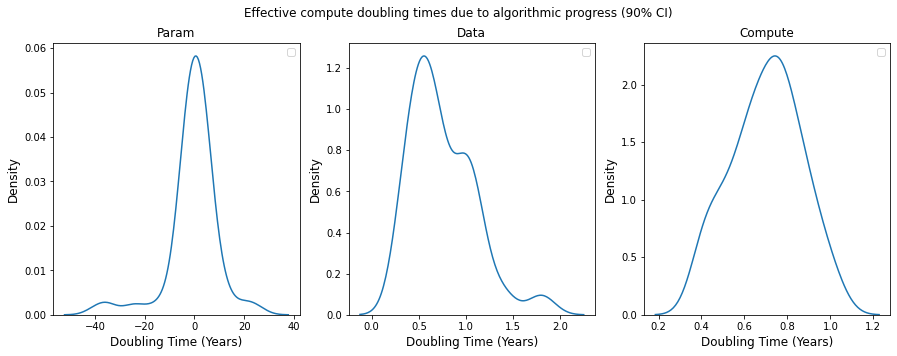

In [24]:
model_doubling_times = estimate_doubling_times(model_num, bootstrap_results)

ci = 90
fig, ax = plt.subplots(1, 3, figsize=(15,5))
estimate_doubling_times(model_num, bootstrap_results)
doubling_times_plot(model_doubling_times[0], ci, ax[0], title="Param")
doubling_times_plot(model_doubling_times[1], ci, ax[1], title="Data")
doubling_times_plot(model_doubling_times[2], ci, ax[2], title="Compute")

fig.suptitle(f'Effective compute doubling times due to algorithmic progress ({ci}% CI)')

filename = f"{date}_model_{model_num}_delta{delta}_doubling_times.pdf"
# plt.savefig(filename, bbox_inches='tight')
# files.download(filename)

plt.show()

In [25]:
ci = 95

print("Param")
print_stats(model_doubling_times[0], ci)
print("\n")

print("Data")
print_stats(model_doubling_times[1], ci)
print("\n")

print("Compute (months)")
print_stats(np.array(model_doubling_times[2]) * 12, ci)

Param
[-77.54952836   0.98283589  29.45083717]


Data
[-0.36142319  0.66766568  2.24090194]


Compute (months)
[ 4.51787288  8.44382833 14.26941928]


### Numerical approach (Appendix G)

In [26]:
# doubling times using numerical "optimal scaling" approach
ci = 95
compute_doubling_times = [compute_doubling_numerical(param, model_num, 2023, compute=1e25) for param in bootstrap_results]

print("Compute (months)")
print_stats(np.array(compute_doubling_times) * 12, ci)

Compute (months)
[ 4.54749572  8.57155622 14.46016107]


## Shapley values and pareto frontiers (section 3.2)

In [27]:
from autograd import grad
import autograd.numpy as anp
from scipy.optimize import fsolve

In [28]:
custom_filename_to_load = None # @param {type:"string"}
#custom_filename_to_load = '2024-01-18_model7_delta0.0025_bootstrap_results.json'
#custom_filename_to_load = '2024-01-17_model7_delta0.0025_post_transformer_bootstrap_results.json'
if custom_filename_to_load:
    with open(custom_filename_to_load, 'r') as f:
        bootstrap_results = json.load(f)
    bootstrap_results = np.array(bootstrap_results)

In [29]:
def anp_log_diff(value, constant):
    return anp.log(value) - anp.log(constant)

variable_names = [
        "alpha_const", "alpha_const_ptb", "alpha_const_wt2",
        "alpha_year", "alpha_year_ptb", "alpha_year_wt2",
        "alpha_param", "alpha_param_ptb", "alpha_param_wt2",
        "beta_const", "beta_const_ptb", "beta_const_wt2",
        "beta_year", "beta_year_ptb", "beta_year_wt2",
        "beta_data", "beta_data_ptb", "beta_data_wt2",
        "alpha_param_t", "beta_data_t", "alpha_rate", "beta_rate"
    ]

def predicted_loss(param, dataset, year_param, year_data, category_ptb, category_wt2, category_transformer, model_num):
    for name in variable_names:
        globals()[name] = params_optimized.get(name, None)

    if model_num == 1:
      alpha_terms = (alpha_const - alpha_year * (year_param - year_const) - alpha_param * anp_log_diff(param, param_const))
      beta_terms = (beta_const - beta_year * (year_data - year_const) - beta_data * anp_log_diff(dataset, dataset_const))
      return anp.exp(alpha_terms) + anp.exp(beta_terms)

    elif model_num == 2:
      alpha_terms = (alpha_const - alpha_param * anp_log_diff(param, param_const))
      beta_terms = (beta_const - beta_year * (year_data - year_const) - beta_data * anp_log_diff(dataset, dataset_const))
      return anp.exp(alpha_terms) + anp.exp(beta_terms)

    elif model_num == 3:
      alpha_terms = (alpha_const - alpha_year * (year_param - year_const) - alpha_param * anp_log_diff(param, param_const))
      beta_terms = (beta_const - beta_data * anp_log_diff(dataset, dataset_const))
      return anp.exp(alpha_terms) + anp.exp(beta_terms)

    elif model_num == 4:
      alpha_year_prime = prime(alpha_year, alpha_year_ptb, alpha_year_wt2, category_ptb, category_wt2)
      alpha_terms = (alpha_const - alpha_year_prime * (year_param - year_const) - alpha_param * anp_log_diff(param, param_const))
      beta_terms = (beta_const - beta_year * (year_data - year_const) - beta_data * anp_log_diff(dataset, dataset_const))
      return anp.exp(alpha_terms) + anp.exp(beta_terms)

    elif model_num == 5:
      beta_year_prime = prime(beta_year, beta_year_ptb, beta_year_wt2, category_ptb, category_wt2)
      alpha_terms = (alpha_const - alpha_year * (year_param - year_const) - alpha_param * anp_log_diff(param, param_const))
      beta_terms = (beta_const - beta_year_prime * (year_data - year_const) - beta_data * anp_log_diff(dataset, dataset_const))
      return anp.exp(alpha_terms) + anp.exp(beta_terms)

    elif model_num == 6:
      alpha_year_prime = prime(alpha_year, alpha_year_ptb, alpha_year_wt2, category_ptb, category_wt2)
      beta_year_prime = prime(beta_year, beta_year_ptb, beta_year_wt2, category_ptb, category_wt2)
      alpha_terms = (alpha_const - alpha_year_prime * (year_param - year_const) - alpha_param * anp_log_diff(param, param_const))
      beta_terms = (beta_const - beta_year_prime * (year_data - year_const) - beta_data * anp_log_diff(dataset, dataset_const))
      return anp.exp(alpha_terms) + anp.exp(beta_terms)

    elif model_num == 7:
      alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
      beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)
      alpha_terms = (alpha_const_prime - alpha_year * (year_param - year_const) - alpha_param * anp_log_diff(param, param_const))
      beta_terms = (beta_const_prime - beta_year * (year_data - year_const) - beta_data * anp_log_diff(dataset, dataset_const))
      return anp.exp(alpha_terms) + anp.exp(beta_terms)

    elif model_num == 8:
      alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
      beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)
      alpha_terms = (alpha_const_prime - alpha_param * anp_log_diff(param, param_const))
      beta_terms = (beta_const_prime - beta_year * (year_data - year_const) - beta_data * anp_log_diff(dataset, dataset_const))
      return anp.exp(alpha_terms) + anp.exp(beta_terms)

    elif model_num == 9:
      alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
      beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)
      alpha_terms = (alpha_const_prime - alpha_year * (year_param - year_const) - alpha_param * anp_log_diff(param, param_const))
      beta_terms = (beta_const_prime - beta_data * anp_log_diff(dataset, dataset_const))
      return anp.exp(alpha_terms) + anp.exp(beta_terms)

    elif model_num == 10:
      alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
      alpha_year_prime = prime(alpha_year, alpha_year_ptb, alpha_year_wt2, category_ptb, category_wt2)
      beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)
      beta_year_prime = prime(beta_year, beta_year_ptb, beta_year_wt2, category_ptb, category_wt2)
      alpha_terms = (alpha_const_prime - alpha_year_prime * (year_param - year_const) - alpha_param * anp_log_diff(param, param_const))
      beta_terms = (beta_const_prime - beta_year_prime * (year_data - year_const) - beta_data * anp_log_diff(dataset, dataset_const))
      return anp.exp(alpha_terms) + anp.exp(beta_terms)

    elif model_num == 11:
      alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
      alpha_year_prime = prime(alpha_year, alpha_year_ptb, alpha_year_wt2, category_ptb, category_wt2)
      alpha_param_prime = prime(alpha_param, alpha_param_ptb, alpha_param_wt2, category_ptb, category_wt2)
      beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)
      beta_year_prime = prime(beta_year, beta_year_ptb, beta_year_wt2, category_ptb, category_wt2)
      beta_data_prime = prime(beta_data, beta_data_ptb, beta_data_wt2, category_ptb, category_wt2)
      alpha_terms = (alpha_const_prime - alpha_year_prime * (year_param - year_const) - alpha_param_prime * anp_log_diff(param, param_const))
      beta_terms = (beta_const_prime - beta_year_prime * (year_data - year_const) - beta_data_prime * anp_log_diff(dataset, dataset_const))
      return anp.exp(alpha_terms) + anp.exp(beta_terms)

    elif model_num == 12:
      alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
      beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)
      alpha_terms = (alpha_const_prime - alpha_param * anp_log_diff(param, param_const))
      beta_terms = (beta_const_prime - beta_data * anp_log_diff(dataset, dataset_const))
      combined_exp = np.exp(-alpha_year * (year_param - year_const))
      return anp.exp(alpha_terms) + anp.exp(beta_terms)

    elif model_num == 13:
      alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
      beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)
      alpha_param_prime = alpha_param * (1 - category_transformer) + alpha_param_t * category_transformer
      beta_data_prime = beta_data * (1 - category_transformer) + beta_data_t * category_transformer
      alpha_terms = (alpha_const_prime - alpha_year * (year_param - year_const) - alpha_param_prime * anp_log_diff(param, param_const))
      beta_terms = (beta_const_prime - beta_year * (year_data - year_const) - beta_data_prime * anp_log_diff(dataset, dataset_const))
      return anp.exp(alpha_terms) + anp.exp(beta_terms)

    elif model_num == 14:
      alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
      beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)
      alpha_param_prime = alpha_param + alpha_rate * (year - year_const)
      beta_data_prime = beta_data + beta_rate * (year - year_const)

      alpha_terms = alpha_const_prime - alpha_param_prime * (np.log(param) - np.log(param_const))
      beta_terms = beta_const_prime - beta_data_prime * (np.log(dataset) - np.log(dataset_const))

      return anp.exp(alpha_terms) + anp.exp(beta_terms)

    elif model_num == 15:
      alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
      beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)
      alpha_param_prime = alpha_param + alpha_rate * (year - year_const)
      beta_data_prime = beta_data + beta_rate * (year - year_const)

      alpha_terms = alpha_const_prime - alpha_year * (year - year_const) - alpha_param_prime * (np.log(param) - np.log(param_const))
      beta_terms = beta_const_prime - beta_year * (year - year_const) - beta_data_prime * (np.log(dataset) - np.log(dataset_const))

      return anp.exp(alpha_terms) + anp.exp(beta_terms)

def param_required(year, data, category_ptb, category_wt2, category_transformer, model_num, loss):
    def obj(log_param):
        return predicted_loss(anp.exp(log_param), data, year, year, category_ptb, category_wt2, category_transformer, model_num) - loss
    x, infodict, ier, mesg = fsolve(obj, fprime=grad(obj), x0 = anp.log(1e+13), full_output=True)
    if ier == 1:
      return anp.exp(x[0])
    else:
      return float("inf")

def data_required(year, param, category_ptb, category_wt2, category_transformer, model_num, loss):
    def obj(log_data):
        return predicted_loss(param, anp.exp(log_data), year, year, category_ptb, category_wt2, category_transformer, model_num) - loss
    x, infodict, ier, mesg = fsolve(obj, fprime=grad(obj), x0 = anp.log(1e+14), full_output=True)
    if ier == 1:
      return anp.exp(x[0])
    else:
      return float("inf")

def pareto_frontier(year, category_ptb, category_wt2, category_transformer, model_num, loss, min_data=1e6, max_data=1e13, num_samples=400):
  x = []
  y = []

  for log_data in anp.linspace(anp.log(max_data), anp.log(min_data), num_samples):
    param = param_required(year, anp.exp(log_data), category_ptb, category_wt2, category_transformer, model_num, loss)

    if param == float("inf"):
      break
    else:
      x.append(anp.exp(log_data))
      y.append(param)

  return x, y

In [30]:
from itertools import permutations

identity = lambda x:  x

def shapley_values(p1, p2, model_num, transform=identity):
    num_param = 4
    p1_change = p1[:num_param]
    p2_change = p2[:num_param]
    (param_start, data_start, year_start, year_start) = p1_change
    (param_end, data_end, year_end, year_end) = p2_change
    total_value = transform(predicted_loss(*p2, model_num)) \
                    - transform(predicted_loss(*p1, model_num))

    if model_num == 13:
      fixed_param = p1[num_param:-1]
      values = [0] * (num_param + 1)
      pi_list = list(permutations(list(range(num_param)) + [-1]))

      for pi in pi_list:
        q1 = list(p1_change) + [p1[-1]]
        for k in pi:
          q2 = deepcopy(q1)
          q2[k] = p2[k]

          values[k] += (transform(predicted_loss(*q2[:num_param], *fixed_param, q2[-1], model_num)) \
                        - transform(predicted_loss(*q1[:num_param], *fixed_param, q2[-1], model_num)))/(total_value * len(pi_list))

    else:
      fixed_param = p1[num_param:]
      values = [0] * num_param
      pi_list = list(permutations(range(num_param)))

      for pi in pi_list:
        q1 = list(p1_change)
        for k in pi:
            q2 = deepcopy(q1)
            q2[k] = p2_change[k]

            values[k] += (transform(predicted_loss(*q2, *fixed_param, model_num)) \
                          - transform(predicted_loss(*q1, *fixed_param, model_num)))/(total_value * len(pi_list))

            q1 = q2

    return values

In [31]:
# param, data, year_param, year_data, category_ptb, category_wt2, category_transformer
models = [[[6.00E+06, 9.29E+05, "2012/12/01", "2012/12/01", 0, 0, 0], "RNN (2012)"], # https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/rnn_ctxt.pdf
          [[1.10E+07, 1.03E+08, "2016/12/13", "2016/12/13", 0, 0, 0], "LSTM (2016)"], # LSTM (WT103) https://arxiv.org/abs/1612.04426
          [[2.47E+08, 1.03E+08, "2018/09/28", "2018/09/28", 0, 0, 1], "Transformer (Adaptive Input Embeddings)"], # https://arxiv.org/abs/1809.10853
          [[2.57E+08, 1.03E+08, "2019/01/09", "2019/01/09", 0, 0, 1], "Transformer-XL Large"], # https://arxiv.org/abs/1901.02860
          [[1.50E+09, 4.00E+09, "2019/02/14", "2019/02/14", 0, 0, 1], "GPT-2 (1542M)"], # https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf
          [[8.30E+09, 4.64E+10, "2019/09/17", "2019/09/17", 0, 0, 1], "Megatron-LM (8.3B)"], # https://arxiv.org/abs/1909.08053
          [[1.75E+11, 4.99E+11, "2020/05/28", "2020/05/28", 0, 0, 1], "GPT-3"], # https://arxiv.org/abs/2005.14165
          [[2.80E+11, 3.00E+11, "2021/12/08", "2021/12/08", 0, 0, 1], "Gopher (280B)"], # https://arxiv.org/abs/2112.11446
          [[7.00E+10, 1.40E+12, "2022/03/29", "2022/03/29", 0, 0, 1], "Chinchilla"]] # https://arxiv.org/abs/2203.15556

for m in models:
    m[0][2] = mdates.date2num(pd.to_datetime(m[0][2])) / 365.242199 + 1970
    m[0][3] = m[0][2]

print(models)

[[[6000000.0, 929000.0, 2012.9167277026497, 2012.9167277026497, 0, 0, 0], 'RNN (2012)'], [[11000000.0, 103000000.0, 2016.9496680475304, 2016.9496680475304, 0, 0, 0], 'LSTM (2016)'], [[247000000.0, 103000000.0, 2018.740260705746, 2018.740260705746, 0, 0, 1], 'Transformer (Adaptive Input Embeddings)'], [[257000000.0, 103000000.0, 2019.0222653598687, 2019.0222653598687, 0, 0, 1], 'Transformer-XL Large'], [[1500000000.0, 4000000000.0, 2019.1208300933486, 2019.1208300933486, 0, 0, 1], 'GPT-2 (1542M)'], [[8300000000.0, 46400000000.0, 2019.7094805849638, 2019.7094805849638, 0, 0, 1], 'Megatron-LM (8.3B)'], [[175000000000.0, 499000000000.0, 2020.4049095378489, 2020.4049095378489, 0, 0, 1], 'GPT-3'], [[280000000000.0, 300000000000.0, 2021.9354008160487, 2021.9354008160487, 0, 0, 1], 'Gopher (280B)'], [[70000000000.0, 1400000000000.0, 2022.2393087442779, 2022.2393087442779, 0, 0, 1], 'Chinchilla']]


In [32]:
for m in models:
    print("Predicted cross entropy loss of %s: %.3f" % (m[1], predicted_loss(*(m[0]), model_num)))

for i in range(len(models)):
    for j in range(i+1, len(models)):
        print("------")
        print("Comparing %s with %s:" % (models[i][1], models[j][1]))
        improv_id = shapley_values(models[i][0], models[j][0], model_num, transform=identity)

        print("\n")
        print(f"Reduction in predicted perplexity: {np.exp(predicted_loss(*models[i][0], model_num)) - np.exp(predicted_loss(*models[j][0], model_num)):.3f}")

        if model_num == 13:
          print("\n")
          print("In linear space, fraction of improvement due to...")
          print("Parameters: %.3f - Data: %.3f - Parameter efficiency: %.3f - Data efficiency: %.3f - Transformer: %.3f" % tuple(improv_id))

        else:
          print("\n")
          print("In linear space, fraction of improvement due to...")
          print("Parameters: %.3f - Data: %.3f - Parameter efficiency: %.3f - Data efficiency: %.3f" % tuple(improv_id))

Predicted cross entropy loss of RNN (2012): 4.434
Predicted cross entropy loss of LSTM (2016): 3.708
Predicted cross entropy loss of Transformer (Adaptive Input Embeddings): 3.186
Predicted cross entropy loss of Transformer-XL Large: 3.165
Predicted cross entropy loss of GPT-2 (1542M): 2.771
Predicted cross entropy loss of Megatron-LM (8.3B): 2.462
Predicted cross entropy loss of GPT-3: 2.080
Predicted cross entropy loss of Gopher (280B): 2.006
Predicted cross entropy loss of Chinchilla: 2.046
------
Comparing RNN (2012) with LSTM (2016):


Reduction in predicted perplexity: 43.489


In linear space, fraction of improvement due to...
Parameters: 0.127 - Data: 0.465 - Parameter efficiency: 0.049 - Data efficiency: 0.359
------
Comparing RNN (2012) with Transformer (Adaptive Input Embeddings):


Reduction in predicted perplexity: 60.085


In linear space, fraction of improvement due to...
Parameters: 0.408 - Data: 0.263 - Parameter efficiency: 0.037 - Data efficiency: 0.292
------
Compar

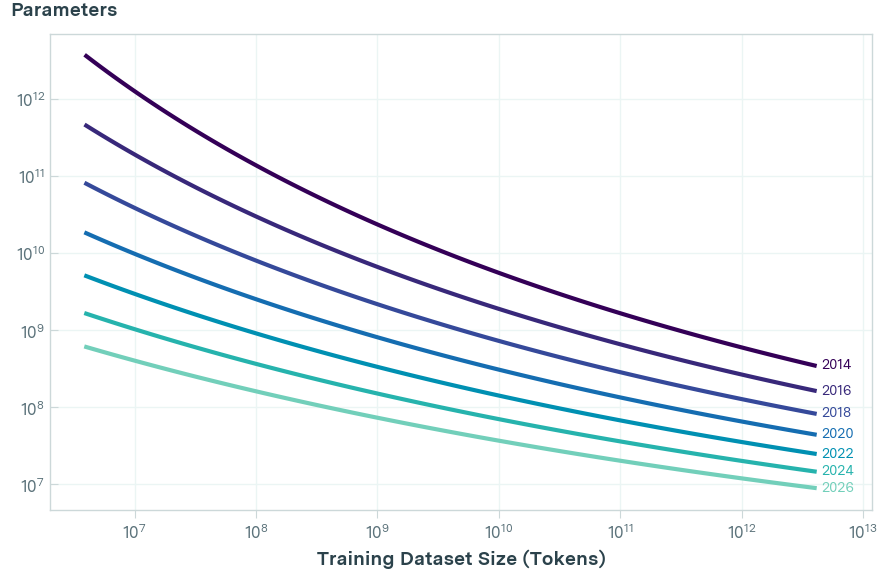

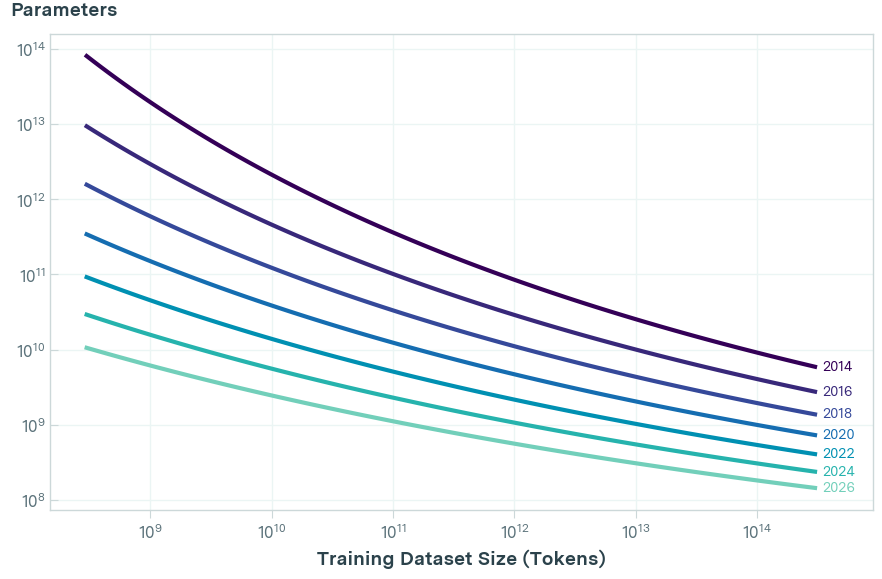

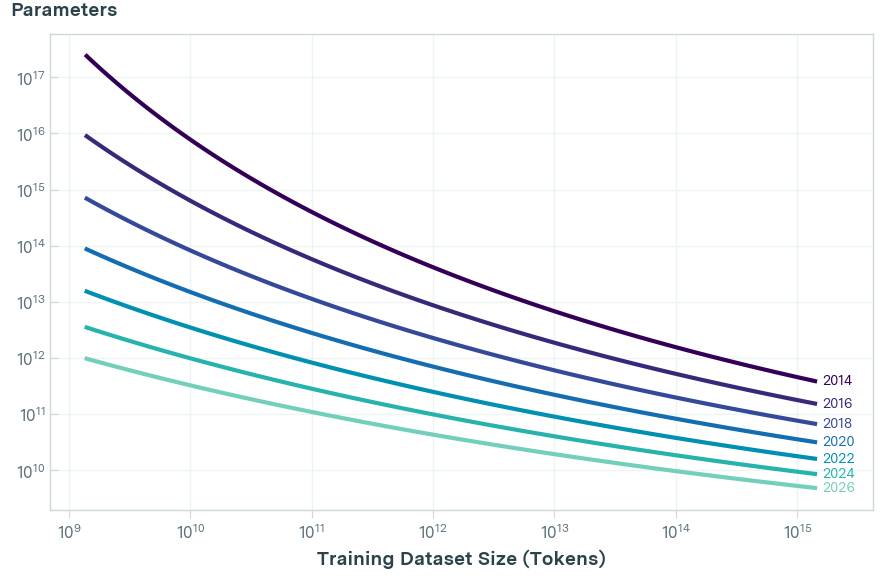

In [33]:
scale_factor = 1e3

what_to_plot = [
    # {"title": "Perplexity = 124.70 (RNN (2012) performance)",
    #  "loss": np.log(124.70),
    #  "cmap": "plasma",
    #  "min_data": 1e2,
    #  "max_data": 1e+6,
    #  "dataset": "ptb",
    # "transformer": 0,
    #  "filename": f"{date}_model{model_num}_delta{delta}_rnn"},
    {"title": "Perplexity = 17.48 (GPT-2 performance)", # included in paper
     "loss": np.log(17.48),
     "cmap": "plasma",
     "min_data": 4.00E+09 / scale_factor,
     "max_data": 4.00E+09 * scale_factor,
     "dataset": "wt103",
     "transformer": 1,
     "filename": f"{date}_model{model_num}_delta{delta}_gpt-2"},
    {"title": "Perplexity = 10.81 (Gopher performance)", # included in paper
     "loss": np.log(10.81),
     "cmap": "plasma",
     "min_data": 3.00E+11 / scale_factor, #1e+7,
     "max_data": 3.00E+11 * scale_factor, #1e+12,
     "dataset": "wt103",
     "transformer": 1,
     "filename": f"{date}_model{model_num}_delta{delta}_gopher"},
    {"title": f"Perplexity = 7.16 (Chinchilla performance)", # included in paper
     "loss": np.log(7.16),
     "cmap": "plasma",
     "min_data": 1.40E+12 / scale_factor, #1e9,
     "max_data": 1.40E+12 * scale_factor, #1e+14,
     "dataset": "wt103",
     "transformer": 1,
     "filename": f"{date}_model{model_num}_delta{delta}_chinchilla"}
]

year_labs = [2014, 2016, 2018, 2020, 2022, 2024, 2026]

for element in what_to_plot:
    with egraphs.epoch_theme():
        plt.figure(figsize=(9, 6))

        # plt.title(element["dataset"].upper() + " " + element["title"], fontsize=18)
        plt.xscale("log")
        plt.yscale("log")
        plt.xticks(fontsize=12, rotation=0)
        plt.yticks(fontsize=12, rotation=0)

        plt.xlabel("Training Dataset Size (Tokens)", fontsize=14)
        plt.ylabel("Parameters", fontsize=14)

        cmap = plt.get_cmap(element["cmap"])
        color_range = 0.6

        if element["dataset"] == "ptb":
            category_ptb = 1
            category_wt2 = 0
        elif element["dataset"] == "wt2":
            category_ptb = 0
            category_wt2 = 1
        else:
            category_ptb = 0
            category_wt2 = 0

        #num_samples = 1000
        num_samples = 100

        gradient = egraphs.get_gradient_colors(len(year_labs) + 2)[::-1]

        for year_index, year in enumerate(year_labs):
            x, y = pareto_frontier(year, category_ptb, category_wt2, element["transformer"], model_num, element["loss"], \
                                   min_data=element["min_data"], max_data=element["max_data"], num_samples=num_samples)
            line = plt.plot(x, y, color=gradient[year_index], linewidth=3)

            if max(y) > 1e+28:
                plt.ylim(bottom=1e+8, top=1e+28)

            y_sep = 0

            plt.annotate(str(year), (x[0], y[0]), xytext=(5, -y_sep * (year_index - len(year_labs)/2)), textcoords="offset points", ha="left", va="center",
                    fontsize=10, color=line[0].get_color(), fontweight="normal")

        # Add a bit of padding for the year numbers
        plt.xlim(right=plt.xlim()[1] * 1.5)

        plt.minorticks_off()

        egraphs.relayout()

        plt.gca().xaxis.set_label_coords(0.5, egraphs.px_to_y_fraction(-40))

        filename = f'{date}_{element["filename"]}.pdf'
        with open(filename, "wb+") as f:
          plt.savefig(filename)
        plt.show()
        files.download(filename)
        plt.close()

## Significance of the transformer (section 3.3)


In [34]:
from scipy.optimize import brentq

# define main functions
def transformer_model(params, year, param, dataset, category_ptb, category_wt2, transformer, model):
    """
    don't use this with model 13
    """
    params_other, gamma_transformer = params[:-1], params[-1]

    transformer_improvement = 1 / (1+np.exp(-gamma_transformer))
    model_pred = model(params_other, year, param, dataset, category_ptb, category_wt2)

    return transformer * transformer_improvement * model_pred + (1 - transformer) * model_pred

def transformer_residuals(params, year, param, dataset, category_ptb, category_wt2, transformer, log_ppl, model, delta):
    residuals = log_ppl - transformer_model(params, year, param, dataset, category_ptb, category_wt2, transformer, model)
    l1_reg = delta * np.sum(np.abs(params))
    return np.mean(np.square(residuals)) + l1_reg

def predict_with_bootstrap(bootstrap_params, year, param, dataset, category_ptb, category_wt2, transformer, model):
    predictions = []
    for params in bootstrap_params:
        prediction = transformer_model(params, year, param, dataset, category_ptb, category_wt2, transformer, model)
        predictions.append(prediction)
    return predictions

def find_a_for_equal_predictions(params, year, param_input, dataset_input, category_ptb, category_wt2, model):
    # Function to find the root (where transformer and non-transformer predictions are equal)
    def equation(a):
        transformer_pred = transformer_model(params, year, param_input, dataset_input, category_ptb, category_wt2, 1, model)
        non_transformer_pred = transformer_model(params, year, a*param_input, a*dataset_input, category_ptb, category_wt2, 0, model)
        # print(transformer_pred - non_transformer_pred)
        return transformer_pred - non_transformer_pred

    # Define lower and upper bounds for 'a'
    a_lower = 0.01  # Adjust as needed based on the expected range of 'a'
    a_upper = 100   # Adjust as needed

    # Solve for 'a' using brentq
    a_solution = brentq(equation, a_lower, a_upper)
    return a_solution

In [35]:
df_transformer = df_head.copy(deep=True)

param_names = ['alpha_const', 'alpha_const_ptb', 'alpha_const_wt2', 'alpha_year', 'alpha_param', \
               'beta_const', 'beta_const_ptb', 'beta_const_wt2', 'beta_year', 'beta_data', \
               'gamma_transformer']

np.random.seed(0)
p0 = np.zeros(len(param_names))
model = model_7
delta = 0.0025

df_transformer['ptb_dummy'] = (df_transformer['dataset_name'] == 'ptb').astype(int)
df_transformer['wt2_dummy'] = (df_transformer['dataset_name'] == 'wt2').astype(int)
df_transformer['transformer'] = df_transformer['Architecture'].apply(lambda x: 1 if x == 'Transformer' else 0).astype(int)

year = df_transformer["publication_date"]
param = df_transformer["param"]
dataset = df_transformer["dataset"]
log_ppl = df_transformer["log_ppl"]
ptb_dummy = df_transformer['ptb_dummy']
wt2_dummy = df_transformer['wt2_dummy']
transformer_dummy = df_transformer['transformer']

param_const = np.min(param)
dataset_const = np.min(dataset)
year_const = np.min(year)

res = minimize(transformer_residuals, p0, args=(year, param, dataset, ptb_dummy, wt2_dummy, transformer_dummy, log_ppl, model, delta), method='SLSQP')
print(res)

print("\n")
params_optimized = pd.Series(res.x, index=param_names)
print("Optimized parameters:")
print(params_optimized)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.05881505857497706
       x: [ 5.060e-01  2.961e-02  9.648e-06 -3.504e-02  7.901e-02
            1.103e+00  1.071e-01  1.116e-01  5.523e-02  2.888e-02
            2.972e+00]
     nit: 44
     jac: [ 5.349e-03 -1.470e-03  2.711e-03 -4.122e-02 -1.995e-02
            4.188e-03  4.992e-04  1.307e-03 -2.206e-02 -3.113e-03
            1.604e-04]
    nfev: 556
    njev: 44


Optimized parameters:
alpha_const          0.506028
alpha_const_ptb      0.029609
alpha_const_wt2      0.000010
alpha_year          -0.035037
alpha_param          0.079008
beta_const           1.102722
beta_const_ptb       0.107080
beta_const_wt2       0.111550
beta_year            0.055229
beta_data            0.028882
gamma_transformer    2.971978
dtype: float64


In [36]:
print("num transformer", np.sum(transformer_dummy))
print("num non-transformer", len(transformer_dummy) - np.sum(transformer_dummy))

num transformer 104
num non-transformer 127


In [37]:
filename_suffix = f"_transformer_bootstrap_results.json"
latest_cached_filename = safe_max([f for f in os.listdir() if f.endswith(filename_suffix)])

In [38]:
if not (use_cached_bootstraps and latest_cached_filename):
    np.random.seed(0)
    n_bootstrap_samples = 100

    bootstrap_results = []
    for i in range(n_bootstrap_samples):
        bootstrap_indices = np.random.choice(np.array(log_ppl.index), size=len(log_ppl), replace=True)

        bootstrap_res = minimize(transformer_residuals, p0, args=(year[bootstrap_indices], param[bootstrap_indices],
                                                    dataset[bootstrap_indices], ptb_dummy[bootstrap_indices],
                                                    wt2_dummy[bootstrap_indices], transformer_dummy[bootstrap_indices], \
                                                                log_ppl[bootstrap_indices], model, delta), method='SLSQP')
        bootstrap_results.append(bootstrap_res.x)

        if i % 5 == 4:
            print(f"Bootstrap steps complete: ({i+1}/{n_bootstrap_samples})")


    confidence_intervals = np.percentile(bootstrap_results, [2.5, 97.5], axis=0)
    standard_errors = np.std(bootstrap_results, axis=0)

    print("Optimized parameters with confidence intervals and standard errors:")
    for i, name in enumerate(param_names):
        print(f"{name}_opt: {params_optimized[i]}  CI: {confidence_intervals[:, i]}  SE: {standard_errors[i]}")

In [39]:
if use_cached_bootstraps and latest_cached_filename:
      with open(latest_cached_filename, 'r') as f:
            bootstrap_results = json.load(f)
else:
      bootstrap_results_to_save = [param_estimates.tolist() if isinstance(param_estimates, np.ndarray) else param_estimates for param_estimates in bootstrap_results]

      with open(f"{date}_transformer_bootstrap_results.json", 'w') as f:
            json.dump(bootstrap_results_to_save, f)

      files.download(f"{date}_transformer_bootstrap_results.json")

In [40]:
custom_filename_to_load = None # @param {type:"string"}
#custom_filename_to_load = '2024-01-12_transformer_bootstrap_results.json'
if custom_filename_to_load:
    with open(custom_filename_to_load, 'r') as f:
        bootstrap_results = json.load(f)
    bootstrap_results = np.array(bootstrap_results)

In [41]:
# inputs
computes = [1e22, 1e25]
category_ptb_input = 0  # Example: 0 or 1
category_wt2_input = 0  # Example: 0 or 1
year_input = 2023

all_a_values = []
all_ceg_values = []

for compute in computes:
  print(f"Compute: {compute} FLOP")
  param_input = (compute/6)**0.5  # compute = 6nd, assuming equal split between data and param
  dataset_input = (compute/6)**0.5  # compute = 6nd, assuming equal split between data and param

  a_values = [find_a_for_equal_predictions(params, year_input, param_input, dataset_input, category_ptb_input, category_wt2_input, model) for params in bootstrap_results]
  ceg_values = [a ** 2 for a in a_values]
  all_a_values.append(a_values)
  all_ceg_values.append(ceg_values)

  print("2.5 percentile", np.percentile(ceg_values, 2.5))
  print("Median", np.median(ceg_values))
  print("97.5 percentile",  np.percentile(ceg_values, 97.5))
  print("\n")

Compute: 1e+22 FLOP
2.5 percentile 3.2056527659844765
Median 6.635783474434504
97.5 percentile 28.191240114840653


Compute: 1e+25 FLOP
2.5 percentile 3.2668160921378133
Median 7.161148055364147
97.5 percentile 45.66154919245873




In [42]:
compute = 1e25
param_input = (compute/6)**0.5  # compute = 6nd, assuming equal split between data and param
dataset_input = (compute/6)**0.5  # compute = 6nd, assuming equal split between data and param
category_ptb_input = 0  # Example: 0 or 1
category_wt2_input = 0  # Example: 0 or 1
year_input = 2023

percentage_reductions = []
for params in bootstrap_results:
    transformer_pred = transformer_model(params, year_input, param_input, dataset_input, category_ptb_input, category_wt2_input, 1, model)
    non_transformer_pred = transformer_model(params, year_input, param_input, dataset_input, category_ptb_input, category_wt2_input, 0, model)
    percentage_reduction = (non_transformer_pred - transformer_pred) / non_transformer_pred * 100
    percentage_reductions.append(percentage_reduction)

np.percentile(percentage_reductions, [2.5, 50, 97.5])

array([2.95407704, 4.59972028, 7.04055733])

# Aggregate doubling time graphs (section 3.1)

Run the following cell if you just want to plot graphs and not the bootstraps

In [43]:
df_double = df_head.copy(deep=True)
df_double['transformer'] = df_double['Architecture'].apply(lambda x: 1 if x == 'Transformer' else 0).astype(int)

param_const = np.min(df_double["param"])
dataset_const = np.min(df_double["dataset"])

year = df_double["publication_date"]
param = df_double["param"]
dataset = df_double["dataset"]
log_ppl = df_double["log_ppl"]
dataset_ptb = df_double['ptb_dummy']
dataset_wt2 = df_double['wt2_dummy']
transformer = df_double['transformer']

year_const = min(year)
data_const = min(dataset)
param_const = min(param)

## Aggregated doubling times

In [44]:
# List of models from LOOCV

text = '''
MSE_model10_delta0.001 with MSE: 0.04847642103308974
MSE_model7_delta0.0025 with MSE: 0.048563819600523625
MSE_model15_delta0.01 with MSE: 0.04862315855821884
MSE_model8_delta0.005 with MSE: 0.04869930867235716
MSE_model15_delta0.005 with MSE: 0.048837041442145145
MSE_model7_delta0.01 with MSE: 0.04891918602256304
MSE_model12_delta0.02 with MSE: 0.048973521894055565
MSE_model10_delta0.0025 with MSE: 0.04900021080864785
MSE_model10_delta0.005 with MSE: 0.04912598962168982
MSE_model12_delta0.005 with MSE: 0.04919516440616078
MSE_model7_delta0.02 with MSE: 0.049196912806226865
MSE_model15_delta0.02 with MSE: 0.049208871605081556
MSE_model9_delta0.02 with MSE: 0.0492496779731775
MSE_model15_delta0.0025 with MSE: 0.0493659178353991
MSE_model12_delta0.0025 with MSE: 0.04939151143709678
MSE_model12_delta0 with MSE: 0.04945719102884973
MSE_model7_delta0.005 with MSE: 0.04951969534757872
MSE_model8_delta0.001 with MSE: 0.04953478220039427
MSE_model9_delta0.01 with MSE: 0.049633670324652365
MSE_model10_delta0 with MSE: 0.0496386829123009
MSE_model15_delta0.001 with MSE: 0.04974714962652067
MSE_model8_delta0.0025 with MSE: 0.04975454905094963
MSE_model9_delta0.001 with MSE: 0.04996074827356605
MSE_model12_delta0.001 with MSE: 0.04996603261650825
MSE_model5_delta0.0025 with MSE: 0.05004010021793135
MSE_model13_delta0.01 with MSE: 0.050051494030613965
MSE_model8_delta0 with MSE: 0.05006104716119326
MSE_model5_delta0.01 with MSE: 0.050067874896543366
MSE_model10_delta0.01 with MSE: 0.05008937352919118
MSE_model5_delta0.001 with MSE: 0.050102107801012694
MSE_model5_delta0 with MSE: 0.05011472488781519
MSE_model12_delta0.01 with MSE: 0.05012300076011561
MSE_model5_delta0.005 with MSE: 0.05014520136923527
MSE_model6_delta0.0025 with MSE: 0.05017838046649957
MSE_model13_delta0.02 with MSE: 0.05018254165191081
MSE_model6_delta0.001 with MSE: 0.050211502555967645
MSE_model7_delta0.001 with MSE: 0.050280869617072406
MSE_model13_delta0.005 with MSE: 0.050282769705482254
MSE_model6_delta0.005 with MSE: 0.050300335175406864
MSE_model6_delta0 with MSE: 0.05033529325347098
MSE_model9_delta0.005 with MSE: 0.05042332825343481
MSE_model7_delta0 with MSE: 0.05048628122937888
MSE_model6_delta0.01 with MSE: 0.05049228245320385
MSE_model9_delta0 with MSE: 0.05049983060306857
MSE_model15_delta0 with MSE: 0.050679997980066255
MSE_model13_delta0.0025 with MSE: 0.050698150865848335
MSE_model9_delta0.0025 with MSE: 0.050967766422513536
MSE_model11_delta0.01 with MSE: 0.0510147019882579
MSE_model10_delta0.02 with MSE: 0.05105248468078686
MSE_model5_delta0.02 with MSE: 0.05113333396716201
MSE_model4_delta0.0025 with MSE: 0.05114297501006555
MSE_model4_delta0 with MSE: 0.05117703202357158
MSE_model4_delta0.001 with MSE: 0.05120147853188074
MSE_model11_delta0.02 with MSE: 0.05127244185762453
MSE_model4_delta0.005 with MSE: 0.051340642077796865
MSE_model6_delta0.02 with MSE: 0.0516182611825561
MSE_model11_delta0.001 with MSE: 0.05185697447326047
MSE_model11_delta0.0025 with MSE: 0.05195536728725606
MSE_model4_delta0.02 with MSE: 0.051991532153223115
MSE_model8_delta0.01 with MSE: 0.05208277509942345
MSE_model3_delta0.02 with MSE: 0.052221513063791865
MSE_model13_delta0 with MSE: 0.052266869604816205
MSE_model4_delta0.01 with MSE: 0.05227314125905681
MSE_model11_delta0.005 with MSE: 0.052300870090183464
MSE_model1_delta0.02 with MSE: 0.05231041850093214
MSE_model3_delta0.01 with MSE: 0.05235382460770766
MSE_model3_delta0.005 with MSE: 0.052486395797718924
MSE_model8_delta0.02 with MSE: 0.052500864949434
MSE_model3_delta0.0025 with MSE: 0.0526157447228351
MSE_model13_delta0.001 with MSE: 0.05267303735461852
MSE_model1_delta0.01 with MSE: 0.05280640607843129
MSE_model11_delta0 with MSE: 0.05280884897040363
MSE_model3_delta0.001 with MSE: 0.05290070492885797
MSE_model3_delta0 with MSE: 0.05293832875988481
MSE_model1_delta0.005 with MSE: 0.052946944362773175
MSE_model1_delta0 with MSE: 0.05304287899814275
MSE_model1_delta0.0025 with MSE: 0.05308409582414382
MSE_model1_delta0.001 with MSE: 0.05309104778457573
MSE_model2_delta0.001 with MSE: 0.05370188343780064
MSE_model2_delta0 with MSE: 0.053708611467090626
MSE_model2_delta0.0025 with MSE: 0.053929303217719
MSE_model2_delta0.005 with MSE: 0.058523467750504106
MSE_model2_delta0.01 with MSE: 0.05859924480221594
MSE_model2_delta0.02 with MSE: 0.059214191942178425
MSE_model14_delta0.01 with MSE: 0.0630178550258326
MSE_model16_delta0.02 with MSE: 0.06310033058892191
MSE_model14_delta0 with MSE: 0.06314328323043893
MSE_model14_delta0.02 with MSE: 0.06335670195075582
MSE_model14_delta0.005 with MSE: 0.06358520065342112
MSE_model14_delta0.001 with MSE: 0.06377413967870402
MSE_model17_delta0.02 with MSE: 0.06411190728148224
MSE_model17_delta0.01 with MSE: 0.06421223220480772
MSE_model17_delta0 with MSE: 0.06427032146119384
MSE_model16_delta0.01 with MSE: 0.06431442632611813
MSE_model17_delta0.001 with MSE: 0.06471762070756258
MSE_model17_delta0.005 with MSE: 0.06474683211854922
MSE_model16_delta0.005 with MSE: 0.06486091163166682
MSE_model14_delta0.0025 with MSE: 0.06519946570962575
MSE_model17_delta0.0025 with MSE: 0.06536816974606262
MSE_model16_delta0 with MSE: 0.06598972281472236
MSE_model16_delta0.001 with MSE: 0.06662594805175184
MSE_model16_delta0.0025 with MSE: 0.06700852485053925
'''

In [45]:
model_delta_pairs = re.findall("model\d+_delta\d.\d+", text)
# unique_model_num = []
names = []
selected_models = []

for i, pair in enumerate(model_delta_pairs):
  model_num = int(re.search("\d+", pair)[0])
  delta = float(re.search("\d.\d+", pair)[0])
  names.append([model_num, delta])
  selected_models.append([globals()[f"model_{model_num}"], delta]) # model_name, delta

  if (i + 1) % 10 == 0:
    break
  # if not (model_num in unique_model_num):
  #   unique_model_num.append(model_num)
  #   names.append([model_num, delta])

names

[[10, 0.001],
 [7, 0.0025],
 [15, 0.01],
 [8, 0.005],
 [15, 0.005],
 [7, 0.01],
 [12, 0.02],
 [10, 0.0025],
 [10, 0.005],
 [12, 0.005]]

### Bootstraps (skip if you just want graphs)

In [46]:
filename_suffix = f"{date}_top_ten_models.json"
latest_cached_filename = safe_max([f for f in os.listdir() if f.endswith(filename_suffix)])

In [47]:
if not (use_cached_bootstraps and latest_cached_filename):
  n_bootstrap_samples = 100

  df_double = df_head.copy(deep=True)
  df_double['transformer'] = df_double['Architecture'].apply(lambda x: 1 if x == 'Transformer' else 0).astype(int)

  all_bootstrap_results = []

  year = df_double["publication_date"]
  param = df_double["param"]
  dataset = df_double["dataset"]
  log_ppl = df_double["log_ppl"]
  dataset_ptb = df_double['ptb_dummy']
  dataset_wt2 = df_double['wt2_dummy']
  transformer = df_double['transformer']

  param_const = np.min(param)
  dataset_const = np.min(dataset)
  year_const = np.min(year)

  # selected_models = zip(models, deltas)
  for model, delta in selected_models:
      model_num_str = re.search(r'\d+', model.__name__).group()
      model_num = int(model_num_str)

      print(f"Model number = {model_num}, delta = {delta}")

      num_params = num_params_in_model(model_num)
      p0 = np.zeros(num_params)

      bootstrap_results = []
      for i in range(n_bootstrap_samples):
        bootstrap_indices = np.random.choice(np.array(log_ppl.index), size=len(log_ppl), replace=True)
        bootstrap_log_ppl = log_ppl[bootstrap_indices]

        bootstrap_res = minimize(residuals, p0, args=(model, year[bootstrap_indices], param[bootstrap_indices], dataset[bootstrap_indices], \
                      dataset_ptb[bootstrap_indices], dataset_wt2[bootstrap_indices], log_ppl[bootstrap_indices], delta, transformer[bootstrap_indices]), method='SLSQP')
        bootstrap_results.append(bootstrap_res.x)

        if i % 5 == 4:
            print(f"Bootstrap steps complete: ({i+1}/{n_bootstrap_samples})")
      print("\n")

      all_bootstrap_results.append(bootstrap_results)

In [48]:
if use_cached_bootstraps and latest_cached_filename:
    with open(latest_cached_filename, 'r') as f:
        all_bootstrap_results = json.load(f)
else:
    all_bootstrap_results_to_save = [
        [param_estimates.tolist() if isinstance(param_estimates, np.ndarray) else param_estimates for param_estimates in model_bootstrap_results]
        for model_bootstrap_results in all_bootstrap_results
    ]

    filename = f"{date}_top_ten_models.json"
    with open(filename, 'w') as f:
        json.dump(all_bootstrap_results_to_save, f)

    files.download(filename)

### Graphs

In [49]:
custom_filename_to_load = None # @param {type:"string"}
#custom_filename_to_load = '2024-01-18_top_ten_models.json'
if custom_filename_to_load:
    with open(custom_filename_to_load, 'r') as f:
        all_bootstrap_results = json.load(f)

model_7_filename = safe_max([f for f in os.listdir() if re.match(r".*_model7_delta.*_bootstrap_results.json", f)])

custom_model_7_filename_to_load = None # @param {type:"string"}
#custom_model_7_filename_to_load = "2024-01-18_model7_delta0.0025_bootstrap_results.json"
if custom_model_7_filename_to_load:
    model_7_filename = custom_model_7_filename_to_load

with open(model_7_filename, 'r') as f:
    model7_bootstrap_results = json.load(f)

In [50]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [51]:
all_compute_doublings = []
for i, bootstrap_results in enumerate(all_bootstrap_results):
  model_num = names[i][0]
  model_name = globals()[f"model_{model_num}"]
  if model_num not in {16, 17}:
    if model_num in {4, 5, 6, 10, 11}: #category_ptb=0, category_wt2=0,
      compute_doublings_wt103 = [compute_doubling_numerical(param, model_num, 2023, compute=1e25, category_ptb=0, category_wt2=0) for param in bootstrap_results]
      compute_doublings_ptb = [compute_doubling_numerical(param, model_num, 2023, compute=1e25, category_ptb=1, category_wt2=0) for param in bootstrap_results]
      compute_doublings_wt2 = [compute_doubling_numerical(param, model_num, 2023, compute=1e25, category_ptb=0, category_wt2=1) for param in bootstrap_results]
      compute_doublings = np.concatenate([compute_doublings_wt103, compute_doublings_ptb, compute_doublings_wt2])
    else:
      compute_doublings = [compute_doubling_numerical(param, model_num, 2023, compute=1e25) for param in bootstrap_results]
    # print(model_num, compute_doublings)
    all_compute_doublings.append(compute_doublings)

model7_doubling_times = estimate_doubling_times(7, model7_bootstrap_results)

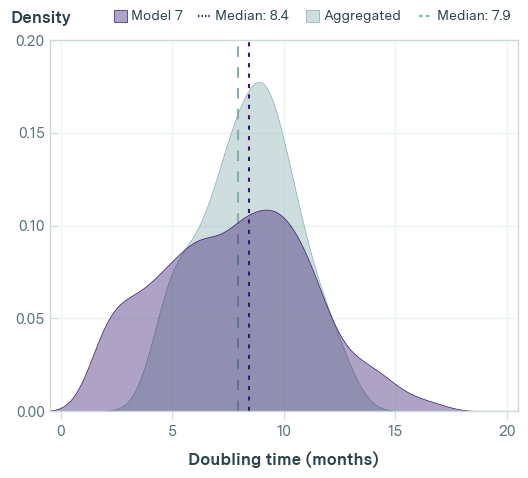

In [55]:
with egraphs.epoch_theme():
    aggregated_top_ten = np.concatenate(all_compute_doublings)
    model7_doublings = np.array(model7_doubling_times[2])
    ci = 95
    filename = f"{date}_aggregate-and-preferred.pdf"
    fontsize = 18

    plt.figure(figsize=egraphs.px_to_in((393, 349)))

    main_model_color = '#361A6D'
    aggregate_color = '#85ADAF'

    median_aggregated = np.median(aggregated_top_ten)
    median_model7 = np.median(model7_doublings)

    sns.kdeplot(data_filter(aggregated_top_ten * 12, ci), fill=True, color=main_model_color, alpha=0.4, label="Model 7", zorder=2)
    plt.axvline(x=median_model7 * 12, color=main_model_color, linestyle=(0, (2, 3)), label=f'Median: {median_model7*12:.1f}', zorder=2)

    sns.kdeplot(data_filter(model7_doublings * 12, ci), fill=True, color=aggregate_color, alpha=0.4, label="Aggregated", zorder=1)
    plt.axvline(x=median_aggregated * 12, color=aggregate_color, linestyle=(0, (5, 5)), label=f'Median: {median_aggregated*12:.1f}', zorder=1)


    plt.xlabel("Doubling time (months)")
    plt.ylabel("Density")
    plt.tick_params(axis='both')
    plt.yticks(np.arange(0, 0.2 + 0.05, 0.05))
    plt.xticks(np.arange(0, 20 + 5, 5))
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
    plt.xlim(-0.5, 20.5)
    plt.legend()

    egraphs.relayout(replace_legend=True)

    plt.savefig(filename)

    plt.show()

In [103]:
ci = 95
np.percentile(np.concatenate(all_compute_doublings), [50 - ci/2, 50, 50 + ci/2]) * 12

array([ 1.41532506,  7.92483018, 17.060203  ])

## Distinct models (robustness check)

In [104]:
# Sorted list of models from LOOCV

text = '''
MSE_model10_delta0.001 with MSE: 0.04847642103308974
MSE_model7_delta0.0025 with MSE: 0.048563819600523625
MSE_model15_delta0.01 with MSE: 0.04862315855821884
MSE_model8_delta0.005 with MSE: 0.04869930867235716
MSE_model15_delta0.005 with MSE: 0.048837041442145145
MSE_model7_delta0.01 with MSE: 0.04891918602256304
MSE_model12_delta0.02 with MSE: 0.048973521894055565
MSE_model10_delta0.0025 with MSE: 0.04900021080864785
MSE_model10_delta0.005 with MSE: 0.04912598962168982
MSE_model12_delta0.005 with MSE: 0.04919516440616078
MSE_model7_delta0.02 with MSE: 0.049196912806226865
MSE_model15_delta0.02 with MSE: 0.049208871605081556
MSE_model9_delta0.02 with MSE: 0.0492496779731775
MSE_model15_delta0.0025 with MSE: 0.0493659178353991
MSE_model12_delta0.0025 with MSE: 0.04939151143709678
MSE_model12_delta0 with MSE: 0.04945719102884973
MSE_model7_delta0.005 with MSE: 0.04951969534757872
MSE_model8_delta0.001 with MSE: 0.04953478220039427
MSE_model9_delta0.01 with MSE: 0.049633670324652365
MSE_model10_delta0 with MSE: 0.0496386829123009
MSE_model15_delta0.001 with MSE: 0.04974714962652067
MSE_model8_delta0.0025 with MSE: 0.04975454905094963
MSE_model9_delta0.001 with MSE: 0.04996074827356605
MSE_model12_delta0.001 with MSE: 0.04996603261650825
MSE_model5_delta0.0025 with MSE: 0.05004010021793135
MSE_model13_delta0.01 with MSE: 0.050051494030613965
MSE_model8_delta0 with MSE: 0.05006104716119326
MSE_model5_delta0.01 with MSE: 0.050067874896543366
MSE_model10_delta0.01 with MSE: 0.05008937352919118
MSE_model5_delta0.001 with MSE: 0.050102107801012694
MSE_model5_delta0 with MSE: 0.05011472488781519
MSE_model12_delta0.01 with MSE: 0.05012300076011561
MSE_model5_delta0.005 with MSE: 0.05014520136923527
MSE_model6_delta0.0025 with MSE: 0.05017838046649957
MSE_model13_delta0.02 with MSE: 0.05018254165191081
MSE_model6_delta0.001 with MSE: 0.050211502555967645
MSE_model7_delta0.001 with MSE: 0.050280869617072406
MSE_model13_delta0.005 with MSE: 0.050282769705482254
MSE_model6_delta0.005 with MSE: 0.050300335175406864
MSE_model6_delta0 with MSE: 0.05033529325347098
MSE_model9_delta0.005 with MSE: 0.05042332825343481
MSE_model7_delta0 with MSE: 0.05048628122937888
MSE_model6_delta0.01 with MSE: 0.05049228245320385
MSE_model9_delta0 with MSE: 0.05049983060306857
MSE_model15_delta0 with MSE: 0.050679997980066255
MSE_model13_delta0.0025 with MSE: 0.050698150865848335
MSE_model9_delta0.0025 with MSE: 0.050967766422513536
MSE_model11_delta0.01 with MSE: 0.0510147019882579
MSE_model10_delta0.02 with MSE: 0.05105248468078686
MSE_model5_delta0.02 with MSE: 0.05113333396716201
MSE_model4_delta0.0025 with MSE: 0.05114297501006555
MSE_model4_delta0 with MSE: 0.05117703202357158
MSE_model4_delta0.001 with MSE: 0.05120147853188074
MSE_model11_delta0.02 with MSE: 0.05127244185762453
MSE_model4_delta0.005 with MSE: 0.051340642077796865
MSE_model6_delta0.02 with MSE: 0.0516182611825561
MSE_model11_delta0.001 with MSE: 0.05185697447326047
MSE_model11_delta0.0025 with MSE: 0.05195536728725606
MSE_model4_delta0.02 with MSE: 0.051991532153223115
MSE_model8_delta0.01 with MSE: 0.05208277509942345
MSE_model3_delta0.02 with MSE: 0.052221513063791865
MSE_model13_delta0 with MSE: 0.052266869604816205
MSE_model4_delta0.01 with MSE: 0.05227314125905681
MSE_model11_delta0.005 with MSE: 0.052300870090183464
MSE_model1_delta0.02 with MSE: 0.05231041850093214
MSE_model3_delta0.01 with MSE: 0.05235382460770766
MSE_model3_delta0.005 with MSE: 0.052486395797718924
MSE_model8_delta0.02 with MSE: 0.052500864949434
MSE_model3_delta0.0025 with MSE: 0.0526157447228351
MSE_model13_delta0.001 with MSE: 0.05267303735461852
MSE_model1_delta0.01 with MSE: 0.05280640607843129
MSE_model11_delta0 with MSE: 0.05280884897040363
MSE_model3_delta0.001 with MSE: 0.05290070492885797
MSE_model3_delta0 with MSE: 0.05293832875988481
MSE_model1_delta0.005 with MSE: 0.052946944362773175
MSE_model1_delta0 with MSE: 0.05304287899814275
MSE_model1_delta0.0025 with MSE: 0.05308409582414382
MSE_model1_delta0.001 with MSE: 0.05309104778457573
MSE_model2_delta0.001 with MSE: 0.05370188343780064
MSE_model2_delta0 with MSE: 0.053708611467090626
MSE_model2_delta0.0025 with MSE: 0.053929303217719
MSE_model2_delta0.005 with MSE: 0.058523467750504106
MSE_model2_delta0.01 with MSE: 0.05859924480221594
MSE_model2_delta0.02 with MSE: 0.059214191942178425
MSE_model14_delta0.01 with MSE: 0.0630178550258326
MSE_model16_delta0.02 with MSE: 0.06310033058892191
MSE_model14_delta0 with MSE: 0.06314328323043893
MSE_model14_delta0.02 with MSE: 0.06335670195075582
MSE_model14_delta0.005 with MSE: 0.06358520065342112
MSE_model14_delta0.001 with MSE: 0.06377413967870402
MSE_model17_delta0.02 with MSE: 0.06411190728148224
MSE_model17_delta0.01 with MSE: 0.06421223220480772
MSE_model17_delta0 with MSE: 0.06427032146119384
MSE_model16_delta0.01 with MSE: 0.06431442632611813
MSE_model17_delta0.001 with MSE: 0.06471762070756258
MSE_model17_delta0.005 with MSE: 0.06474683211854922
MSE_model16_delta0.005 with MSE: 0.06486091163166682
MSE_model14_delta0.0025 with MSE: 0.06519946570962575
MSE_model17_delta0.0025 with MSE: 0.06536816974606262
MSE_model16_delta0 with MSE: 0.06598972281472236
MSE_model16_delta0.001 with MSE: 0.06662594805175184
MSE_model16_delta0.0025 with MSE: 0.06700852485053925
'''

In [105]:
model_delta_pairs = re.findall("model\d+_delta\d.\d+", text)
unique_model_num = []
names = []
selected_models = []

for pair in model_delta_pairs:
  model_num = int(re.search("\d+", pair)[0])
  delta = float(re.search("\d.\d+", pair)[0])
  if not (model_num in unique_model_num):
    unique_model_num.append(model_num)
    names.append([model_num, delta])
    selected_models.append([globals()[f"model_{model_num}"], delta]) # model_name, delta

names

[[10, 0.001],
 [7, 0.0025],
 [15, 0.01],
 [8, 0.005],
 [12, 0.02],
 [9, 0.02],
 [5, 0.0025],
 [13, 0.01],
 [6, 0.0025],
 [11, 0.01],
 [4, 0.0025],
 [3, 0.02],
 [1, 0.02],
 [2, 0.001],
 [14, 0.01],
 [16, 0.02],
 [17, 0.02]]

### Bootstraps (skip if you just want graphs)

In [109]:
filename_suffix = f"_distinct_models_bootstrap_estimates_all_models.json"
latest_cached_filename = safe_max([f for f in os.listdir() if f.endswith(filename_suffix)])


In [110]:
if not (use_cached_bootstraps and latest_cached_filename):
  n_bootstrap_samples = 100

  df_double = df_head.copy(deep=True)
  df_double['transformer'] = df_double['Architecture'].apply(lambda x: 1 if x == 'Transformer' else 0).astype(int)

  param_const = np.min(df_double["param"])
  dataset_const = np.min(df_double["dataset"])

  all_bootstrap_results = []

  year = df_double["publication_date"]
  param = df_double["param"]
  dataset = df_double["dataset"]
  log_ppl = df_double["log_ppl"]
  dataset_ptb = df_double['ptb_dummy']
  dataset_wt2 = df_double['wt2_dummy']
  transformer = df_double['transformer']

  year_const = min(year)
  data_const = min(dataset)
  param_const = min(param)

  for model, delta in selected_models:
      model_num_str = re.search(r'\d+', model.__name__).group()
      model_num = int(model_num_str)

      print(f"Model number = {model_num}, delta = {delta}")

      num_params = num_params_in_model(model_num)
      p0 = np.zeros(num_params)

      bootstrap_results = []
      for i in range(n_bootstrap_samples):
        bootstrap_indices = np.random.choice(np.array(log_ppl.index), size=len(log_ppl), replace=True)
        bootstrap_log_ppl = log_ppl[bootstrap_indices]

        bootstrap_res = minimize(residuals, p0, args=(model, year[bootstrap_indices], param[bootstrap_indices], dataset[bootstrap_indices], \
                      dataset_ptb[bootstrap_indices], dataset_wt2[bootstrap_indices], log_ppl[bootstrap_indices], delta, transformer[bootstrap_indices]), method='SLSQP')
        bootstrap_results.append(bootstrap_res.x)

        if i % 5 == 4:
            print(f"Bootstrap steps complete: ({i+1}/{n_bootstrap_samples})")
      print("\n")

      all_bootstrap_results.append(bootstrap_results)

In [111]:
if use_cached_bootstraps and latest_cached_filename:
    with open(latest_cached_filename, 'r') as f:
        all_bootstrap_results = json.load(f)
else:
    all_bootstrap_results_to_save = [
        [param_estimates.tolist() if isinstance(param_estimates, np.ndarray) else param_estimates for param_estimates in model_bootstrap_results]
        for model_bootstrap_results in all_bootstrap_results
    ]

    filename = f"{date}_distinct_models_bootstrap_estimates_all_models.json"
    with open(filename, 'w') as f:
        json.dump(all_bootstrap_results_to_save, f)

    files.download(filename)

### Graphs

In [112]:
custom_filename_to_load = None
#custom_filename_to_load = '2024-01-18_distinct_models_bootstrap_estimates_all_models.json'
if custom_filename_to_load:
    with open(custom_filename_to_load, 'r') as f:
        all_bootstrap_results = json.load(f)

In [113]:
all_compute_doublings = []
for i, bootstrap_results in enumerate(all_bootstrap_results):
  model_num = names[i][0]
  model_name = globals()[f"model_{model_num}"]
  if model_num not in {16, 17}:
    if model_num in {4, 5, 6, 10, 11}: #category_ptb=0, category_wt2=0,
      compute_doublings_wt103 = [compute_doubling_numerical(param, model_num, 2023, compute=1e25, category_ptb=0, category_wt2=0) for param in bootstrap_results]
      compute_doublings_ptb = [compute_doubling_numerical(param, model_num, 2023, compute=1e25, category_ptb=1, category_wt2=0) for param in bootstrap_results]
      compute_doublings_wt2 = [compute_doubling_numerical(param, model_num, 2023, compute=1e25, category_ptb=0, category_wt2=1) for param in bootstrap_results]
      compute_doublings = np.concatenate([compute_doublings_wt103, compute_doublings_ptb, compute_doublings_wt2])
    else:
      compute_doublings = [compute_doubling_numerical(param, model_num, 2023, compute=1e25) for param in bootstrap_results]
    # print(model_num, compute_doublings)
    all_compute_doublings.append(compute_doublings)

/tmp/ipykernel_176800/3061356232.py:46: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_176800/1506341361.py:55: RuntimeWarning:

divide by zero encountered in log



/tmp/ipykernel_176800/1566308802.py:17: FutureWarning:

Passing `palette` without assigning `hue` is deprecated.

/tmp/ipykernel_176800/1566308802.py:17: UserWarning:

The palette list has more values (17) than needed (14), which may not be intended.

/home/edu/.local/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning:

54.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/home/edu/.local/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning:

22.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/home/edu/.local/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning:

35.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/home/edu/.local/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning:

42.9% of the points cannot be placed; you may want to decrease the size of

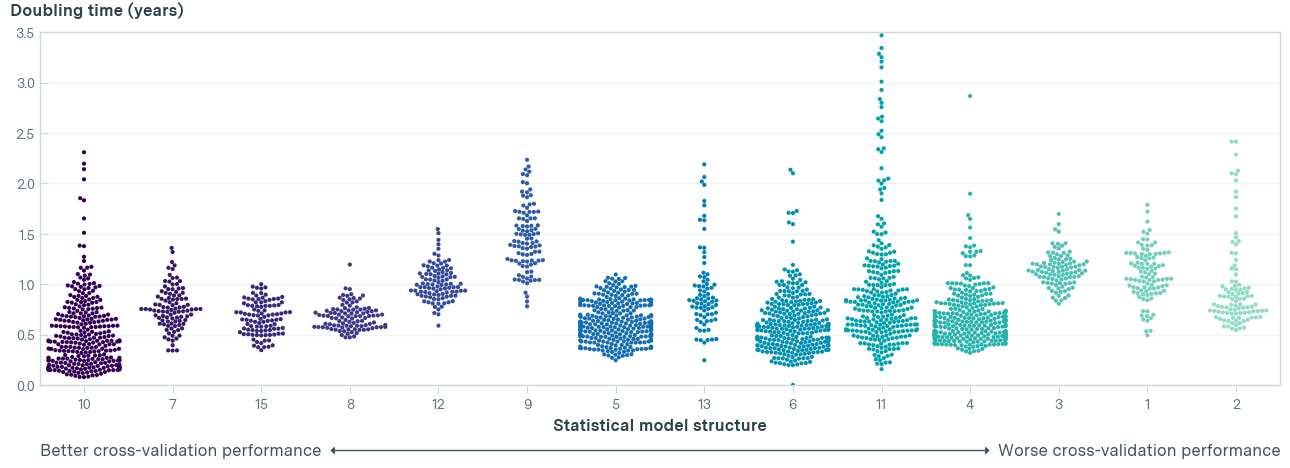

In [122]:
from matplotlib.patches import FancyArrowPatch

def compute_violins(all_compute_doublings, ci, ylim, filename, names, data_filter, date, num_bootstraps=100, year=False, **kwargs):
    with egraphs.epoch_theme():
        data = []
        # Data preparation
        for i, compute_doubling in enumerate(all_compute_doublings):
            data.append({'model': f'{names[i][0]}', 'value': data_filter(compute_doubling, ci)})

        df = pd.DataFrame([(d['model'], val) for d in data for val in d['value']], columns=['Model', 'Doubling Time'])
        if not year:
            df['Doubling Time'] = df['Doubling Time'] * 12  # convert to months

        # Plotting
        #sns.set(style="whitegrid")
        plt.figure(figsize=egraphs.px_to_in((949, 350)))
        ax = sns.swarmplot(y='Doubling Time', x='Model', data=df, palette=egraphs.get_gradient_colors(len(names))[::-1], s=3)
        ax.set_ylabel('Doubling time (years)' if year else 'Doubling time (months)')
        ax.set_xlabel('Statistical model structure')

        y_min, y_max = ylim
        ax.set_ylim(y_min, y_max * 1.5)
        ax.set_xticklabels(ax.get_xticklabels())
        ax.set_ylim(*ylim)
        ax.set_yticklabels(ax.get_yticklabels())

        arrow_y = -0.65

        arrow_color = '#3E555E'
        arrow_style = "<|-|>,head_width=2,head_length=2"

        arrow_left_text = mpl.text.Text(-0.5, arrow_y, 'Better cross-validation performance', fontsize=12, color=arrow_color,
                ha='left', va='center', weight='medium', clip_on=False)
        arrow_right_text = mpl.text.Text(13.5, arrow_y, 'Worse cross-validation performance', fontsize=12, color=arrow_color,
                ha='right', va='center', weight='medium', clip_on=False)
        arrow = FancyArrowPatch((2.75, arrow_y), (10.25, arrow_y), arrowstyle=arrow_style, lw=1, color=arrow_color, clip_on=False)

        ax.add_artist(arrow_left_text)
        ax.add_artist(arrow_right_text)
        ax.add_artist(arrow)

        egraphs.relayout()

        plt.gcf().subplots_adjust(bottom=egraphs.px_to_y_fraction(65))

        plt.savefig(filename, format='pdf', bbox_inches='tight')
        plt.show()


ci = 100
compute_violins(all_compute_doublings[:-1], ci, (0, 3.5),
                f"{date}_compute_doubling_swarmplot_all_models.pdf",
                names, data_filter, date, year=True,
                title=f"Compute efficiency doubling times ({ci}% CI)")

# Dummy for year (section 3.1)

In [123]:
df_main = df_head.copy(deep=True)

param_names = ['alpha_const', 'alpha_const_ptb', 'alpha_const_wt2', 'alpha_year', 'alpha_param', \
               'beta_const', 'beta_const_ptb', 'beta_const_wt2', 'beta_year', 'beta_data', \
               'alpha_year_dummy', 'beta_year_dummy'
               ]

np.random.seed(0)
p0 = np.zeros(len(param_names))
delta = 0.0025
split_year = 2017

year = df_main["publication_date"]
param = df_main["param"]
dataset = df_main["dataset"]
log_ppl = df_main["log_ppl"]
ptb_dummy = df_main['ptb_dummy']
wt2_dummy = df_main['wt2_dummy']
year_dummy = df_main["Year"] >= split_year

param_const = np.min(param)
dataset_const = np.min(dataset)
year_const = np.min(year)

def model_year(params, year, param, dataset, category_ptb, category_wt2, category_year):
    alpha_const, alpha_const_ptb, alpha_const_wt2, alpha_year, alpha_param, \
    beta_const, beta_const_ptb, beta_const_wt2, beta_year, beta_data, \
    alpha_year_dummy, beta_year_dummy = params

    alpha_const_prime = prime(alpha_const, alpha_const_ptb, alpha_const_wt2, category_ptb, category_wt2)
    beta_const_prime = prime(beta_const, beta_const_ptb, beta_const_wt2, category_ptb, category_wt2)
    alpha_year_prime = alpha_year + alpha_year_dummy * category_year
    beta_year_prime = beta_year + beta_year_dummy * category_year

    alpha_terms = (alpha_const_prime - alpha_year_prime * (year - year_const) - alpha_param * log_diff(param, param_const))
    beta_terms = (beta_const_prime - beta_year_prime * (year - year_const) - beta_data * log_diff(dataset, dataset_const))

    return np.exp(alpha_terms) + np.exp(beta_terms)

def residuals_year(params, year, param, dataset, category_ptb, category_wt2, category_year, log_ppl, delta):
    residuals = log_ppl - model_year(params, year, param, dataset, category_ptb, category_wt2, category_year)
    l1_reg = delta * np.sum(np.abs(params))
    return np.mean(np.square(residuals)) + l1_reg

res = minimize(residuals_year, p0, args=(year, param, dataset, ptb_dummy, wt2_dummy, year_dummy, log_ppl, delta), method='SLSQP')
print(res)

print("\n")
params_optimized = pd.Series(res.x, index=param_names)
print("Optimized parameters:")
print(params_optimized)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.049180189755223945
       x: [ 4.666e-01  1.874e-01  4.257e-02  5.577e-03  8.967e-02
            1.123e+00  9.715e-05  9.840e-02  1.378e-02  2.967e-02
           -3.883e-02  4.114e-02]
     nit: 35
     jac: [-1.597e-03  4.859e-06  1.122e-04  2.283e-02  1.603e-02
           -3.984e-03 -2.441e-03 -1.210e-03  2.676e-02  1.456e-02
            2.380e-02  2.707e-02]
    nfev: 474
    njev: 35


Optimized parameters:
alpha_const         0.466551
alpha_const_ptb     0.187420
alpha_const_wt2     0.042573
alpha_year          0.005577
alpha_param         0.089667
beta_const          1.122824
beta_const_ptb      0.000097
beta_const_wt2      0.098399
beta_year           0.013778
beta_data           0.029671
alpha_year_dummy   -0.038833
beta_year_dummy     0.041142
dtype: float64


In [124]:
df_main['predicted_log_ppl'] = model_year(res.x, year, param, dataset, ptb_dummy, wt2_dummy, year_dummy)
r2_score_value = r2_score(df_main["log_ppl"], df_main['predicted_log_ppl'])

fig = px.scatter(df_main, x='predicted_log_ppl', y=df_main["log_ppl"], hover_data=['system'], trendline='ols')

fig.add_annotation(
        x=0.50,
        y=0.95,
        xref="paper",
        yref="paper",
        text=f"r2 total = {r2_score_value:.2f}",
        showarrow=False,
)

fig.update_layout(title="Nonlinear model: actual vs predicted cross entropy",
    xaxis_title="Predicted Log PPL",
    yaxis_title="Actual Log PPL")

fig.show()

In [60]:
filename_suffix = f"_pre-post-bootstraps.json"
latest_cached_filename = safe_max([f for f in os.listdir() if f.endswith(filename_suffix)])

In [61]:
if not (use_cached_bootstraps and latest_cached_filename):
    np.random.seed(0)
    n_bootstrap_samples = 100

    bootstrap_results = []
    for i in range(n_bootstrap_samples):
        bootstrap_indices = np.random.choice(np.array(log_ppl.index), size=len(log_ppl), replace=True)

        bootstrap_res = minimize(residuals_year, p0, args=(year[bootstrap_indices], param[bootstrap_indices],
                                                        dataset[bootstrap_indices], ptb_dummy[bootstrap_indices],
                                                        wt2_dummy[bootstrap_indices], year_dummy[bootstrap_indices], log_ppl[bootstrap_indices], delta), method='SLSQP')
        bootstrap_results.append(bootstrap_res.x)

        if i % 5 == 4:
            print(f"Bootstrap steps complete: ({i+1}/{n_bootstrap_samples})")


    confidence_intervals = np.percentile(bootstrap_results, [2.5, 97.5], axis=0)
    standard_errors = np.std(bootstrap_results, axis=0)

    print("Optimized parameters with confidence intervals and standard errors:")
    for i, name in enumerate(param_names):
        print(f"{name}_opt: {params_optimized[i]}  CI: {confidence_intervals[:, i]}  SE: {standard_errors[i]}")

In [62]:
split_years = [2016, 2017, 2018, 2019, 2020]

if not (use_cached_bootstraps and latest_cached_filename):
  all_bootstrap_results = []
  np.random.seed(0)
  n_bootstrap_samples = 100

  for split_year in split_years:
    print(split_year)
    year_dummy = df_main["Year"] >= split_year
    bootstrap_results = []

    for i in range(n_bootstrap_samples):
        bootstrap_indices = np.random.choice(np.array(log_ppl.index), size=len(log_ppl), replace=True)

        bootstrap_res = minimize(residuals_year, p0, args=(year[bootstrap_indices], param[bootstrap_indices],
                                                        dataset[bootstrap_indices], ptb_dummy[bootstrap_indices],
                                                        wt2_dummy[bootstrap_indices], year_dummy[bootstrap_indices], log_ppl[bootstrap_indices], delta), method='SLSQP')
        bootstrap_results.append(bootstrap_res.x)

        if i % 5 == 4:
            print(f"Bootstrap steps complete: ({i+1}/{n_bootstrap_samples})")
    print("\n")

    all_bootstrap_results.append(bootstrap_results)

In [63]:
if use_cached_bootstraps and latest_cached_filename:
      with open(latest_cached_filename, 'r') as f:
            all_bootstrap_results = json.load(f)
else:
    all_bootstrap_results_to_save = [
        [param_estimates.tolist() if isinstance(param_estimates, np.ndarray) else param_estimates for param_estimates in model_bootstrap_results]
        for model_bootstrap_results in all_bootstrap_results
    ]

    filename = f"{date}_pre-post-bootstraps.json"
    with open(filename, 'w') as f:
        json.dump(all_bootstrap_results_to_save, f)

    files.download(filename)

In [64]:
custom_filename_to_load = None # @param {type:"string"}
#custom_filename_to_load = '2024-02-20_pre-post-bootstraps.json'
if custom_filename_to_load:
    with open(custom_filename_to_load, 'r') as f:
        all_bootstrap_results = json.load(f)

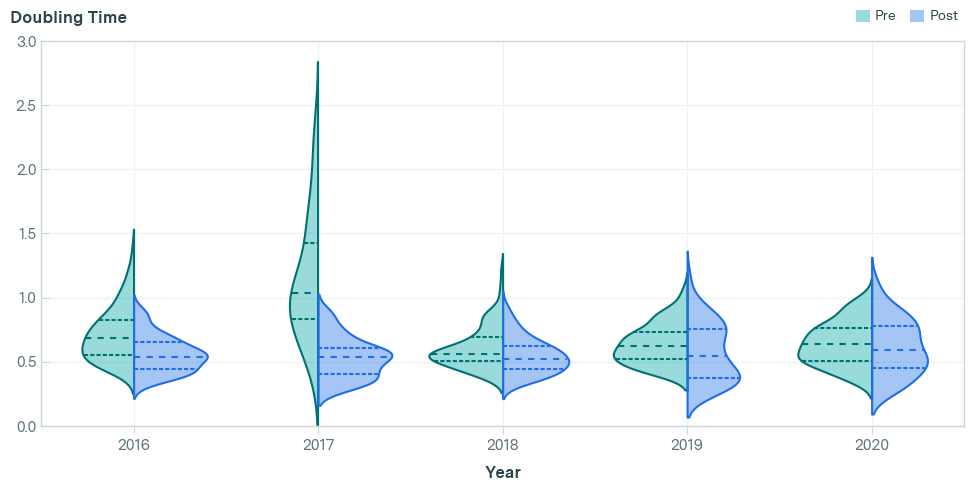

In [102]:
with egraphs.epoch_theme():
    compute_doublings_pre = []
    compute_doublings_post = []

    ci = 90

    for bootstrap_results in all_bootstrap_results:
      results = np.array(bootstrap_results).T

      param_doubling_pre = results[4] / results[3] * np.log(2)
      data_doubling_pre = results[9] / results[8] * np.log(2)
      compute_doubling_pre = (1/param_doubling_pre + 1/data_doubling_pre) ** (-1)

      param_doubling_post = results[4] / (results[3] + results[-2]) * np.log(2)
      data_doubling_post = results[9] / (results[8] + results[-1]) * np.log(2)
      compute_doubling_post = (1/param_doubling_post + 1/data_doubling_post) ** (-1)

      compute_doublings_pre.append(data_filter(compute_doubling_pre, ci))
      compute_doublings_post.append(data_filter(compute_doubling_post, ci))

    data = []
    for year, pre_data, post_data in zip(split_years, compute_doublings_pre, compute_doublings_post):
        for pre, post in zip(pre_data, post_data):
            data.append([year, "Pre", pre])
            data.append([year, "Post", post])

    doublings_df = pd.DataFrame(data, columns=["Year", "Time", "Doubling Time"])

    pre_color = '#00A5A6'
    pre_line_color = '#007173'
    post_color = '#1F6EE5'
    post_line_color = '#1F6EE5'

    plt.figure(figsize=(10, 5))
    sns.violinplot(x="Year", y="Doubling Time", hue="Time", data=doublings_df, split=True, inner="quart", palette=[pre_color, post_color])

    alpha = 0.4

    # Set fill transparency
    for i, violin in enumerate(plt.gca().collections):
        violin.set_edgecolor(pre_line_color if i % 2 == 0 else post_line_color)
        violin.set_facecolor(mpl.colors.to_rgba(pre_color if i % 2 == 0 else post_color, alpha=alpha))

    # Set the line color
    for i, artist in enumerate([c for c in plt.gca().get_children() if isinstance(c, mpl.lines.Line2D)]):
        artist.set_color(pre_line_color if (i // 3) % 2 == 0 else post_line_color)
        artist.set_linestyle((0, (3, 3)) if i % 3 == 1 else (0, (2, 1)))

    plt.gca().xaxis.grid(True)

    plt.xlabel('Year')
    plt.ylabel('Doubling Time')
    plt.ylim(0,3)

    egraphs.relayout(replace_legend=True)

    # Very hackily fix the legend colors
    rect_index = 0
    for artist in plt.gca().get_children():
        if isinstance(artist, mpl.patches.Rectangle):
            if rect_index in (0, 2):
                artist.set_facecolor(mpl.colors.to_rgba(pre_color, alpha=alpha))
            if rect_index in (1, 3):
                artist.set_facecolor(mpl.colors.to_rgba(post_color, alpha=alpha))
            rect_index += 1

    plt.savefig("pre-post.pdf")
    plt.show()

# Contributions to effective compute graph (section 3.2)

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
date = datetime.today().strftime('%Y-%m-%d')
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates

In [105]:
def add_brace(ax, start, end, num_years):
    center = np.sqrt(start * end)
    upper_half = [
        (num_years, start),
        (num_years + 0.2, start),
        (num_years, start),
        (num_years + 0.5, center)
    ]
    lower_half = [
        (num_years + 0.5, center),
        (num_years, end),
        (num_years + 0.2, end),
        (num_years, end)
    ]
    points = upper_half + lower_half
    cmds = [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4] * 2
    brace_path = Path(points, cmds)
    ax.add_patch(patches.PathPatch(brace_path, fc="none", transform=ax.transData))

def human_format(x, pos):
    magnitude = 0
    while abs(x) >= 1000:
        magnitude += 1
        x /= 1000.0
    return f"{x:.0f}{' KMBTPEZY'[magnitude]}"

In [106]:
# param, data, year_param, year_data, category_ptb, category_wt2, category_transformer
models = [[[6.60E+07, 9.29E+05, "2014/09/08", "2014/09/08", 1, 0, 0], "Large regularized LSTM"], # https://arxiv.org/abs/1409.2329
          [[1.10E+07, 1.03E+08, "2016/12/13", "2016/12/13", 0, 0, 0], "LSTM (2016)"], # LSTM (WT103) https://arxiv.org/abs/1612.04426
          [[2.47E+08, 1.03E+08, "2018/09/28", "2018/09/28", 0, 0, 1], "Transformer (Adaptive Input Embeddings)"], # https://arxiv.org/abs/1809.10853
          [[2.57E+08, 1.03E+08, "2019/01/09", "2019/01/09", 0, 0, 1], "Transformer-XL Large"], # https://arxiv.org/abs/1901.02860
          [[1.50E+09, 4.00E+09, "2019/02/14", "2019/02/14", 0, 0, 1], "GPT-2 (1542M)"], # https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf
          [[8.30E+09, 4.64E+10, "2019/09/17", "2019/09/17", 0, 0, 1], "Megatron-LM (8.3B)"], # https://arxiv.org/abs/1909.08053
          [[1.75E+11, 4.99E+11, "2020/05/28", "2020/05/28", 0, 0, 1], "GPT-3"], # https://arxiv.org/abs/2005.14165
          [[2.80E+11, 3.00E+11, "2021/12/08", "2021/12/08", 0, 0, 1], "Gopher (280B)"], # https://arxiv.org/abs/2112.11446
          [[7.00E+10, 1.40E+12, "2022/03/29", "2022/03/29", 0, 0, 1], "Chinchilla"]] # https://arxiv.org/abs/2203.15556

# [[6.00E+06, 9.29E+05, "2012/12/01", "2012/12/01", 0, 0, 0], "RNN (2012)"], # https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/rnn_ctxt.pdf

for m in models:
    m[0][2] = mdates.date2num(pd.to_datetime(m[0][2])) / 365.242199 + 1970
    m[0][3] = m[0][2]

print(models)

[[[66000000.0, 929000.0, 2014.685417086759, 2014.685417086759, 1, 0, 0], 'Large regularized LSTM'], [[11000000.0, 103000000.0, 2016.9496680475304, 2016.9496680475304, 0, 0, 0], 'LSTM (2016)'], [[247000000.0, 103000000.0, 2018.740260705746, 2018.740260705746, 0, 0, 1], 'Transformer (Adaptive Input Embeddings)'], [[257000000.0, 103000000.0, 2019.0222653598687, 2019.0222653598687, 0, 0, 1], 'Transformer-XL Large'], [[1500000000.0, 4000000000.0, 2019.1208300933486, 2019.1208300933486, 0, 0, 1], 'GPT-2 (1542M)'], [[8300000000.0, 46400000000.0, 2019.7094805849638, 2019.7094805849638, 0, 0, 1], 'Megatron-LM (8.3B)'], [[175000000000.0, 499000000000.0, 2020.4049095378489, 2020.4049095378489, 0, 0, 1], 'GPT-3'], [[280000000000.0, 300000000000.0, 2021.9354008160487, 2021.9354008160487, 0, 0, 1], 'Gopher (280B)'], [[70000000000.0, 1400000000000.0, 2022.2393087442779, 2022.2393087442779, 0, 0, 1], 'Chinchilla']]


[[907.8671328671335, 346.9963417713234], [907.8671328671335, 346.9963417713234], [913.4633328671334, 346.9963417713234], [918.0003828671335, 351.5332417713234], [918.0003828671335, 357.1297417713234], [918.0003828671335, 418.97620145304137], [918.0003828671335, 422.54980145304137], [919.5102828671335, 425.95675145304136], [922.1579328671335, 428.3576514530414], [922.1579328671335, 428.3576514530414], [922.1579328671335, 428.3576514530414], [919.5102828671335, 430.75840145304136], [918.0003828671335, 434.16535145304135], [918.0003828671335, 437.73910145304137], [918.0003828671335, 499.5857111347593], [918.0003828671335, 505.1819111347594], [913.4633328671334, 509.71896113475935], [907.8671328671335, 509.71896113475935], [907.8671328671335, 509.71896113475935]]
[[907.8671328671335, 67.27921136803312], [907.8671328671335, 67.27921136803312], [913.4633328671334, 67.27921136803312], [918.0003828671335, 71.81611136803312], [918.0003828671335, 77.41261136803311], [918.0003828671335, 195.41218

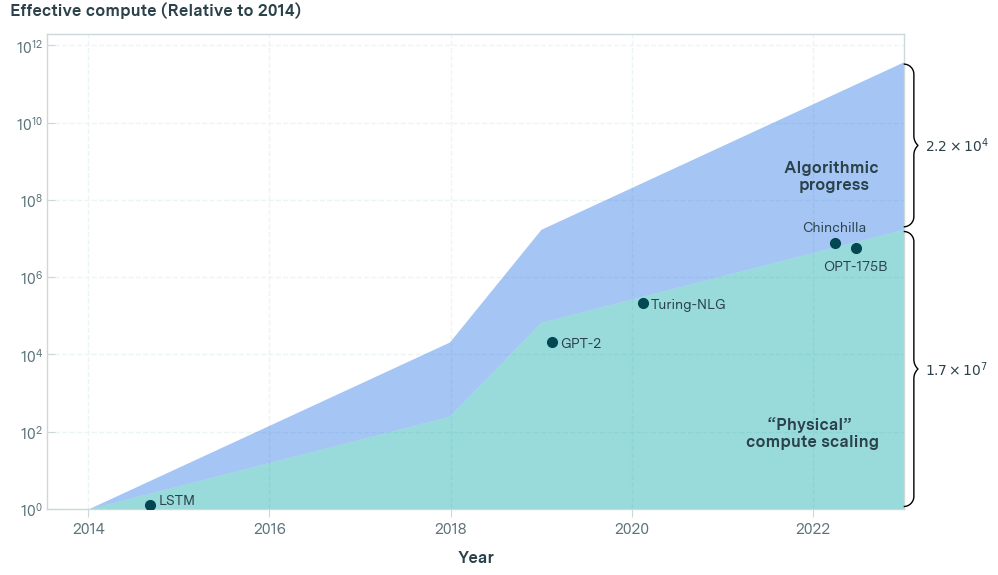

In [109]:
with egraphs.epoch_theme():
  split1 = 2018
  split2 = 2019
  doubling1 = 6 / 12
  doubling2 = 1.5 / 12
  doubling3 = 6 / 12
  T_algo = 7.5 / 12

  num_years = 9
  year_start = 2014
  years = np.linspace(year_start, year_start + num_years, 500)
  t1 = np.where(years >= split1)[0][0] - 1
  t2 = np.where(years >= split2)[0][0] - 1

  C_phys1, C_phys2, C_phys3 = [], [], []
  for year in years:
    if year < split1:
      C_phys1.append(2 ** ((year - year_start) / doubling1))
    elif year < split2:
      C_phys2.append(2 ** ((year - years[t1]) / doubling2))
    else:
      C_phys3.append(2 ** ((year - years[t2]) / doubling3))

  C_phys2 = np.multiply(C_phys2, C_phys1[-1])
  C_phys3 = np.multiply(C_phys3, C_phys2[-1])
  C_phys = np.concatenate([C_phys1, C_phys2, C_phys3])
  C_algo = 2 ** ((years - year_start) / T_algo)
  C_t = C_phys * C_algo

  fig, ax = plt.subplots(figsize=(10, 6))
  ax.fill_between(years, 1, C_phys, label="Physical compute contribution", color='#00A5A6', alpha=0.4, linewidth=0)
  ax.fill_between(years, C_phys, C_t, label="Algorithmic contribution", color='#1F6EE5', alpha=0.4, linewidth=0)

  total_contrib_algo = C_algo[-1]#float(round(C_algo[-1], -3))
  total_contrib_phys = C_phys[-1]

  plt.text(year_start + 8.23, np.exp(np.log(float(total_contrib_phys * total_contrib_algo)) / 1.4), f'Algorithmic \nprogress', fontsize=12, ha='center', weight='bold')
  plt.text(year_start + 7.99, np.exp(np.log(total_contrib_phys) / 4.5), f'“Physical” \ncompute scaling', fontsize=12, ha='center', weight='bold')

  ax.yaxis.set_major_formatter(FuncFormatter(human_format))

  models_to_plot = [
      "Large regularized LSTM",
      # "genCNN + dyn eval",
      "LSTM (Hebbian, Cache, MbPA)",
      "GPT-2 (1542M)",
      "Megatron-LM (8.3B)",
      "Turing-NLG",
      # "Gopher (280B)",
      "Chinchilla",
      "OPT-175B"
  ]

  models_to_name = {
      "GPT-2 (1542M)":          ["GPT-2",      'left center_baseline', (6, 0)],
      "Large regularized LSTM": ["LSTM",       'left center_baseline', (6, 4)],
      "Turing-NLG":             ["Turing-NLG", 'left center_baseline', (6, 0)],
      "Chinchilla":             ["Chinchilla", 'center bottom', (0, 6)],
      "OPT-175B":               ["OPT-175B",   'center top', (0, -9)],
  }

  models_to_plot = [m for m in models_to_plot if m in models_to_name]

  df_main.loc[df_main['system'] == 'Gopher (280B)', 'param'] = 280e9
  df_main.loc[df_main['system'] == 'Gopher (7.1B)', 'param'] = 7.1e9
  df_main.loc[df_main['system'] == 'Gopher (280B)', 'Training Compute'] = 6.31E+23
  df_main.loc[df_main['system'] == 'Gopher (7.1B)', 'Training Compute'] = 1.28E+22

  compute_models = df_main[["system", "publication_date", "Training Compute"]].dropna().sort_values(by=["publication_date"])
  compute_const = np.min(compute_models["Training Compute"])
  # compute_const = 6 * param_const * dataset_const
  models_added = set()
  for _, model in compute_models.iterrows():
      color = '#034752'
      text_color = '#2B424B'

      system = model["system"]

      if system in models_to_plot and system not in models_added:
          models_added.add(system)

          xcoord = model["publication_date"]
          ycoord = model["Training Compute"] / compute_const
          plt.plot(xcoord, ycoord, color=color, marker='o', markersize=7, zorder=3)

          if system in models_to_name.keys():
              element = models_to_name[system]
              model_name = element[0]
              ha, va = element[1].split()
              offset = element[2]
              model_xcoord = xcoord
              model_ycoord = ycoord
              plt.annotate(model_name, xy=(model_xcoord, model_ycoord), xytext=offset, textcoords='offset points',
                      fontsize=10, ha=ha, va=va, color=text_color, weight='medium')

  # plt.xlim(2012, 2012 + num_years)  # extend xlim to make space for curly bracket
  plt.yscale('log')
  plt.xlabel('Year')
  plt.ylabel(f'Effective compute (Relative to {year_start})')
  plt.grid(True, which="both", ls="--")
  # plt.legend()

  # Customize x-axis ticks
  current_ticks = plt.xticks()[0]
  plt.xlim(None, max(years))
  plt.ylim(1, 2e12)
  # plt.title('Effective Compute of Frontier Models', fontsize=18, pad=20)

  egraphs.relayout()

  # OK, now we add the right braces

  # Give a bit more space for the braces
  fig.subplots_adjust(right=1-egraphs.px_to_x_fraction(85))

  # Adding braces
  margin_y = 1.15

  egraphs.add_brace(ax, years[-1], C_phys[-1]*margin_y, C_t[-1]/ margin_y, transform=ax.transData)
  egraphs.add_brace(ax, years[-1], 1e0*margin_y, C_phys[-1]/margin_y, transform=ax.transData)

  def format_scientific(num):
      if num == 0:
          return "0"
      exponent = np.floor(np.log10(np.abs(num)))
      coefficient = num / 10**exponent
      return r"${:.1f} \times 10^{{{}}}$".format(coefficient, int(exponent))

  formatted_algo = format_scientific(total_contrib_algo)
  formatted_phys = format_scientific(total_contrib_phys)

  # Brace texts
  plt.annotate(format_scientific(total_contrib_algo), xy=(years[-1], np.sqrt(C_phys[-1] * C_t[-1])), xytext=(15, 0), textcoords='offset points',
          fontsize=10, ha='left', va='center', weight='medium')
  plt.annotate(format_scientific(total_contrib_phys), xy=(years[-1], np.sqrt(1 * C_phys[-1])), xytext=(15, 0), textcoords='offset points',
          fontsize=10, ha='left', va='center', weight='medium')

  filename = f"{date}_relative_contribution.pdf"
  plt.savefig(filename)
  files.download(filename)

  plt.show()

In [170]:
compute_models

,system,publication_date,Training Compute
192,Large regularized LSTM,2014.684932,9.100000e+16
229,genCNN + dyn eval,2015.205479,7.300000e+16
196,QRNN,2018.084932,3.600000e+17
17,4 layer QRNN (h=2500),2018.219178,2.400000e+17
83,"LSTM (Hebbian, Cache, MbPA)",2018.232877,2.400000e+19
13,Transformer (Adaptive Input Embeddings),2018.739726,7.300000e+18
219,Transformer-XL Large,2019.021918,1.090000e+19
220,Transformer-XL-ptb,2019.021918,1.090000e+19
134,GPT-2 (1542M),2019.120548,1.500000e+21
133,GPT-2 (1542M),2019.120548,1.500000e+21


In [171]:
import plotly.express as px
px.scatter(compute_models, x="publication_date", y="Training Compute", log_y=True, hover_name="system")

## Check for instances of >10,000x compute gain via algorithmic progress

In [69]:
pd.options.display.max_rows = None

Our main dataset

In [70]:
df_main = df_head.copy(deep=True)
df_main.dropna(subset=["Training Compute"], inplace=True)
df_new = df_main[["system", "publication_date", "Training Compute", "ppl"]]
delta = 1

all_data = []

for idx, row in df_new.iterrows():
  data_subset = df_new[df_new["ppl"] < row["ppl"] * delta]
  data_subset = data_subset[data_subset["publication_date"] > row["publication_date"]]
  data_subset = data_subset[data_subset["Training Compute"] < row["Training Compute"]]
  if len(data_subset) > 0:
    min_compute = min(data_subset["Training Compute"])
    row_min = data_subset.loc[data_subset["Training Compute"] == min_compute]
    compute_diff = row["Training Compute"] / min_compute
    data = [row["system"], row_min.iloc[0]["system"], compute_diff]
    all_data.append(data)

pd.DataFrame(all_data, columns=["reference system", "new system", "compute decrease"])

,reference system,new system,compute decrease
0,NMST+GPT-2,Transformer + GFM,14.925373
1,Transformer (Adaptive Input Embeddings),SRU++ Base,1.258621
2,Transformer+Recurrent Windows of Context,SRU++ Base,20.172414
3,All-attention network + adaptive span,SRU++ Base,7.931034
4,Transformer-XL DeFINE (141M),TransformerXL + spectrum control,13.478261
5,Transformer-XL DeFINE (107M),TransformerXL + spectrum control,11.304348
6,Adaptive LSTM + DeFINE,TransformerXL + spectrum control,13.478261
7,DeLight,SRU++ Base,4.137931
8,"LSTM (Hebbian, Cache, MbPA)",AdvSoft + 4 layer QRNN + dynamic evaluation,66.666667
9,Decaying Fast Weights Transformer,Transformer + GFM,1.616915


Dataset used for the graphs showing compute decrease for three specific systems

In [71]:
import io
import os
uploaded = files.upload()
df_main = pd.read_csv(io.BytesIO(uploaded['202401 benchmark dataset.csv']))
os.remove('202401 benchmark dataset.csv')

# rename columns
column_renames = {
    'Publication date': 'publication_date',
    'Perplexity (WT103)': 'ppl',
    'System': 'system',
}
df_main = df_main.rename(columns=column_renames)

df_main.dropna(subset=["Training Compute"], inplace=True)
df_new = df_main[["system", "publication_date", "Training Compute", "ppl"]]
delta = 1

all_data = []

for idx, row in df_new.iterrows():
  data_subset = df_new[df_new["ppl"] < row["ppl"] * delta]
  data_subset = data_subset[data_subset["publication_date"] > row["publication_date"]]
  data_subset = data_subset[data_subset["Training Compute"] < row["Training Compute"]]
  if len(data_subset) > 0:
    min_compute = min(data_subset["Training Compute"])
    row_min = data_subset.loc[data_subset["Training Compute"] == min_compute]
    compute_diff = row["Training Compute"] / min_compute
    data = [row["system"], row_min.iloc[0]["system"], compute_diff]
    all_data.append(data)

pd.DataFrame(all_data, columns=["reference system", "new system", "compute decrease"])

,reference system,new system,compute decrease
0,OPT-175B,Llama 2 7B,6.785714
1,OPT-66B + RE-PLUG,GPT3-6.7B (rerun of original),9.166667
2,Chinchilla,Llama 2 7B,6.904762
3,LLaMA-33B,Llama 2 7B,1.904762
4,GPT-2 (1542M),SRU++ Large only 2 attention layers (k=5),537.500000
5,TransformerXL+RelationLM,SRU++ Base,551.724138
6,Transformer + GFM,SRU++ Base,12.586207
7,Decaying Fast Weights Transformer,SRU++ Base,13.620690
8,NMST+GPT-2,SRU++ Base,20.689655
9,Progressive LRD,SRU++ Base,10.689655


Computer vision dataset

In [72]:
df_ex = pd.read_csv('https://raw.githubusercontent.com/Besiroglu/computer_vision_data/main/imagenet.csv')
df4 = df_ex[["url",	"publication_date",	"year",	"fractional_year", "model_name",	"extra_data",	"top_1_error",	"top_5_error",	"final_compute_estimate",	"nr_training_images",	"parameter_count", "reimplementation",	"input_size_test"]]
df4 = df4[df4["top_1_error"].notna() & df4["final_compute_estimate"].notna() & df4["parameter_count"].notna()]

exclude_models = ["GreedyNAS-B", "NASNet-A", "AmoebaNet-A"]

for model_name in exclude_models:
    df4 = df4[df4["model_name"] != model_name]

df4["data"] = df4["nr_training_images"]
df4["model_size"] = df4["parameter_count"]
df4["year"] = df4["fractional_year"]

df_new = df4[["model_name", "year", "final_compute_estimate", "top_1_error"]]
delta = 1

all_data = []

for idx, row in df_new.iterrows():
  data_subset = df_new[df_new["top_1_error"] > row["top_1_error"] * delta]
  data_subset = data_subset[data_subset["year"] > row["year"]]
  data_subset = data_subset[data_subset["final_compute_estimate"] < row["final_compute_estimate"]]
  if len(data_subset) > 0:
    min_compute = min(data_subset["final_compute_estimate"])
    row_min = data_subset.loc[data_subset["final_compute_estimate"] == min_compute]
    compute_diff = row["final_compute_estimate"] / min_compute
    data = [row["model_name"], row_min.iloc[0]["model_name"], compute_diff]
    all_data.append(data)

pd.DataFrame(all_data, columns=["reference system", "new system", "compute decrease"])

,reference system,new system,compute decrease
0,"MSRA (C, PReLU)",SE-ResNet-50,13.288591
1,ResNet-50,SE-ResNet-50,2.711409
2,ResNet-152,Xception,9.250000
3,ResNet-101,SE-ResNet-50,5.416107
4,ResNeXt-101 64x4,SE-ResNet-50,10.067114
5,Very Deep PolyNet,SE-ResNet-50,8.926174
6,SE-ResNet-152,AlphaX-1,1.797521
7,Oct-ResNet-152 (alpha=0.5),PyConvResNet-101,2.316206
8,NoisyStudent (EfficientNet-L2),DynamicViT-LV-M/0.8,16576.576577
9,BiT-L,DynamicViT-LV-M/0.8,712.612613
